## Problem Statement

At some point or the other almost each one of us has used an Ola or Uber for taking a ride. 

Ride hailing services are services that use online-enabled platforms to connect between passengers and local drivers using their personal vehicles. In most cases they are a comfortable method for door-to-door transport. Usually they are cheaper than using licensed taxicabs. Examples of ride hailing services include Uber and Lyft.

<img src="2560px-Ride_hailing_services_Wikivoyage_banner.jpg">

To improve the efficiency of taxi dispatching systems for such services, it is important to be able to predict how long a driver will have his taxi occupied. If a dispatcher knew approximately when a taxi driver would be ending their current ride, they would be better able to identify which driver to assign to each pickup request.

In this competition, we are challenged to build a model that predicts the total ride duration of taxi trips in New York City.

# 1. Exploratory Data Analysis
Let's check the data files! According to the data description we should find the following columns:

 - **id** - a unique identifier for each trip
 - **vendor_id** - a code indicating the provider associated with the trip record
 - **pickup_datetime** - date and time when the meter was engaged
 - **dropoff_datetime** - date and time when the meter was disengaged
 - **passenger_count** - the number of passengers in the vehicle (driver entered value)
 - **pickup_longitude** - the longitude where the meter was engaged
 - **pickup_latitude** - the latitude where the meter was engaged
 - **dropoff_longitude** - the longitude where the meter was disengaged
 - **dropoff_latitude** - the latitude where the meter was disengaged
 - **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration** - (target) duration of the trip in seconds

Here, we have 2 variables dropoff_datetime and store_and_fwd_flag which are not available before the trip starts and hence will not be used as features to the model.

## 1.1 Load Libraries

In [1]:
# Import libraries

%matplotlib inline
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
Start = dt.datetime.now()
print("Start:",Start)

Start: 2022-10-20 02:06:50.855882


## 1.2 Load Data

In [3]:
# load data file

df = pd.read_csv('EDA_NYC_Taxi (1)/nyc_taxi_trip_duration.csv')
df.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id1080784          2  2016-02-29 16:40:21  2016-02-29 16:47:01   
1  id0889885          1  2016-03-11 23:35:37  2016-03-11 23:53:57   
2  id0857912          2  2016-02-21 17:59:33  2016-02-21 18:26:48   
3  id3744273          2  2016-01-05 09:44:31  2016-01-05 10:03:32   
4  id0232939          1  2016-02-17 06:42:23  2016-02-17 06:56:31   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.953918        40.778873         -73.963875   
1                2        -73.988312        40.731743         -73.994751   
2                2        -73.997314        40.721458         -73.948029   
3                6        -73.961670        40.759720         -73.956779   
4                1        -74.017120        40.708469         -73.988182   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.771164                  N            400  
1         40.694931                  N           1100  
2         40.774918                  N           1635  
3         40.780628                  N           1141  
4         40.740631                  N            848

## 1.3 File structure and content

In [4]:
print('We have {} rows.'.format(df.shape[0]))
print('We have {} columns'.format(df.shape[1]))
df.iloc[1,:]

We have 729322 rows.
We have 11 columns


id                              id0889885
vendor_id                               1
pickup_datetime       2016-03-11 23:35:37
dropoff_datetime      2016-03-11 23:53:57
passenger_count                         2
pickup_longitude               -73.988312
pickup_latitude                 40.731743
dropoff_longitude              -73.994751
dropoff_latitude                40.694931
store_and_fwd_flag                      N
trip_duration                        1100
Name: 1, dtype: object

At first glance, we can see the types of each variable and what they look like. 

## 1.4 Missing Values
Knowing about missing values is important because they indicate how much we don’t know about our data. Making inferences based on just a few cases is often unwise. In addition, many modelling procedures break down when missing values are involved and the corresponding rows will either have to be removed completely or the values need to be estimated somehow.

In [5]:
np.sum(pd.isnull(df))

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Fortunately, in this dataset we do not have any missing values which is great.

## 1.5 Reformatting features & Checking Consistency
There are a variety of features within the dataset and it is important to convert them into the right format such that we can analyse them easily. This would include converting datetime features and string features. 

Also, one important thing is never to take assumptions without backing it with data. Here, as you can see the trip duration can also be calculated with pick up and drop off datetime. We will check whether the given duration is consistent with the calculated trip duration 

In [6]:
df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [7]:
# converting strings to datetime features
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

# Converting yes/no flag to 1 and 0
df['store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag.values == 'Y')

#Checking Data Consistency in data wrt pickup to drop datetime and trip duration 
df['check_trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).map(lambda x: x.total_seconds())

duration_difference = df[np.abs(df['check_trip_duration'].values  - df['trip_duration'].values) > 1]
duration_difference.shape

(0, 12)

This implies that there is no inconsistency in data wrt the drop datetime and trip duration

## 1.6 Target Exploration
In this section we will take a look at the trip duration which is the target variable. It is crucial to understand it in detail as this is what we are trying to predict accurately.

In [8]:
df['trip_duration'].describe()/3600 # Trip duration in hours

count    202.589444
mean       0.264508
std        1.073507
min        0.000278
25%        0.110278
50%        0.184167
75%        0.298611
max      538.815556
Name: trip_duration, dtype: float64

Woah! There is a trip with duration of **539 hours**. This is a huge outlier and might create problems at the prediction stage. One idea is to log transform the trip duration before prediction to visualise it better.

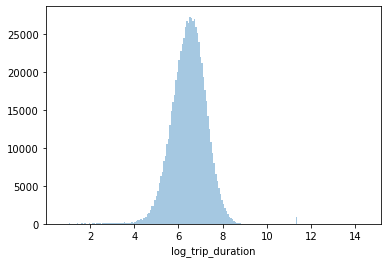

In [9]:
df['log_trip_duration'] = np.log(df['trip_duration'].values + 1)
ax = sns.distplot(df['log_trip_duration'], kde = False, bins = 200)
plt.show()

In [10]:
#0.075 minor ticks unit
df_peak = df[(df['log_trip_duration']>6.5) & (df['log_trip_duration']<6.575)]['log_trip_duration'].value_counts()
df_peak = pd.DataFrame(data=df_peak)
df_peak.sum()

log_trip_duration    29090
dtype: int64

In [11]:
#0.075 minor ticks unit
df_lt10s = df[(df['log_trip_duration']<2.35)]['log_trip_duration'].value_counts()
df_lt10s = pd.DataFrame(data=df_lt10s)
df_lt10s.sum()

log_trip_duration    995
dtype: int64

We find:

1. The majority of rides follow a rather smooth distribution that looks almost log-normal with a peak just around exp(6.5)  i.e. about **11 minutes**.
2. There are several suspiciously short rides with less than 10 seconds duration.
3. As discussed earlier, there are a few huge outliers near 12.

## 1.7 Univariate Visualization
First of all, let us look at some of the binary features. Looking at each feature might uncover some insight that might be useful at later modelling stages

### Passenger count, Vendor_id, store_and_fwd_flag 

Text(0, 0.5, 'Frequency')

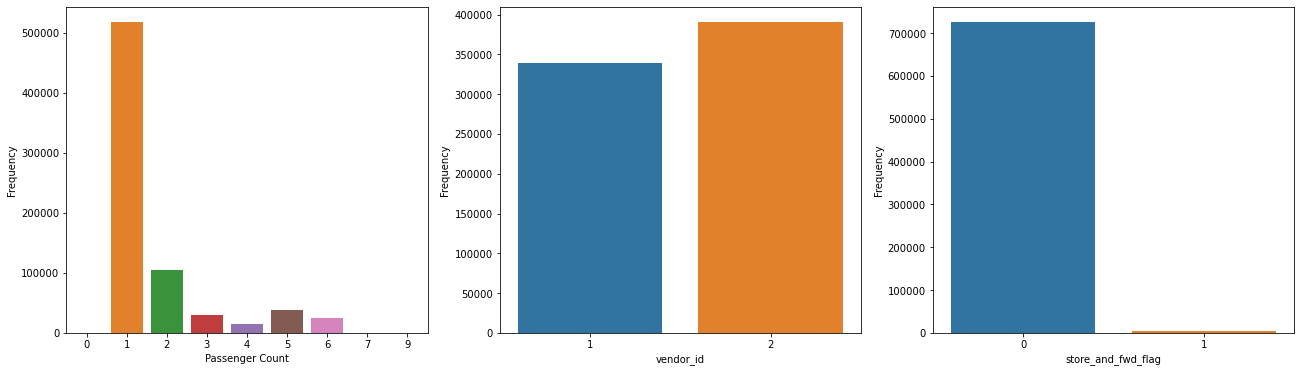

In [12]:
# Binary Features
plt.figure(figsize=(22, 6))
#fig, axs = plt.subplot(ncols=2)

# Passenger Count
plt.subplot(131)
sns.countplot(df['passenger_count'])
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')

# vendor_id
plt.subplot(132)
sns.countplot(df['vendor_id'])
plt.xlabel('vendor_id')
plt.ylabel('Frequency')

# store_and_fwd_flag
plt.subplot(133)
sns.countplot(df['store_and_fwd_flag'])
plt.xlabel('store_and_fwd_flag')
plt.ylabel('Frequency')


Observations:
1. Most of the trips involve only 1 passenger. There are trips with 7-9 passengers but they are very low in number.
2. Vendor 2 has more number of trips as compared to vendor 1
3. The store_and_fwd_flag values, indicating whether the trip data was sent immediately to the vendor (“0”) or held in the memory of the taxi because there was no connection to the server (“1”), show that there was almost no storing taking place

Now, we will delve into the datetime features to understand the trend of number of hourly/monthly/daily taxi trips 

In [13]:
df['pickup_datetime'].min(), df['pickup_datetime'].max()

(Timestamp('2016-01-01 00:01:14'), Timestamp('2016-06-30 23:59:37'))

Clearly, These trips are for first 6 months of 2016. To look at trends, we first need to extract month, week days and hour of day from the pickup date.

### Month of the Year

In [14]:
df['month_of_year'] = df['pickup_datetime'].dt.month

In [15]:
df['month_of_year'].value_counts().sort_index()

1    114401
2    119364
3    128316
4    125634
5    124201
6    117406
Name: month_of_year, dtype: int64

In [16]:
month_check = df[df['pickup_datetime'].dt.month==6]
# weekday = today.weekday()
# weekday
month_check.head(1)

id  vendor_id     pickup_datetime    dropoff_datetime  \
7  id1663798          2 2016-06-19 16:48:14 2016-06-19 17:06:35   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
7                1         -73.96389        40.765434         -73.872429   

   dropoff_latitude  store_and_fwd_flag  trip_duration  check_trip_duration  \
7           40.7742                   0           1101               1101.0   

   log_trip_duration  month_of_year  
7           7.004882              6

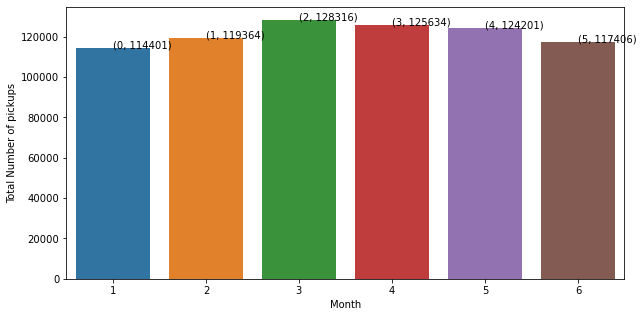

In [17]:
# Month_of_Year
plt.figure(figsize=(10,5))
sns.countplot(df['month_of_year'])
plt.xlabel('Month')
plt.ylabel('Total Number of pickups')
for i, j in enumerate(df['month_of_year'].value_counts().sort_index()):
    plt.text(i, j, '({}, {})'.format(i, j))
plt.show()

As expected, the number of trips are lowest in Jan'16 and still low in Feb'16 pertaining to holidays and public holiday respectively. And, we observe a decline MoM possibly due to dip in market share of the ridehailing app. 

### Day of Week and Hour of Day

In [18]:
df['day_of_week'] = df['pickup_datetime'].dt.weekday
df['hour_of_day'] = df['pickup_datetime'].dt.hour

In [19]:
day_check = df[df['pickup_datetime'].dt.weekday==4]
day_check.head(1)

id  vendor_id     pickup_datetime    dropoff_datetime  \
1  id0889885          1 2016-03-11 23:35:37 2016-03-11 23:53:57   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
1                2        -73.988312        40.731743         -73.994751   

   dropoff_latitude  store_and_fwd_flag  trip_duration  check_trip_duration  \
1         40.694931                   0           1100               1100.0   

   log_trip_duration  month_of_year  day_of_week  hour_of_day  
1           7.003974              3            4           23

In [20]:
df['day_of_week'].value_counts().sort_index()

0     93972
1    101254
2    105074
3    109344
4    111744
5    110252
6     97682
Name: day_of_week, dtype: int64

<Figure size 1584x432 with 0 Axes>

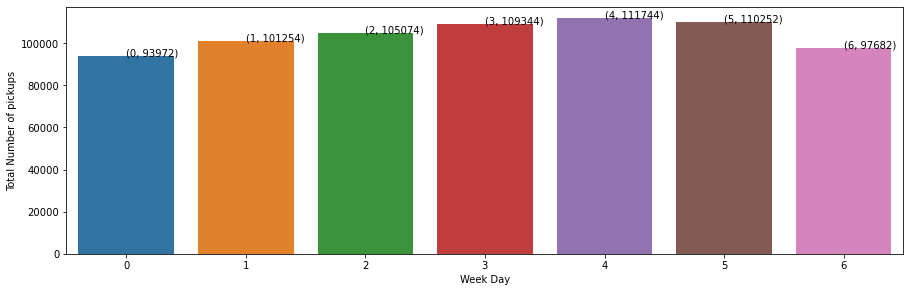

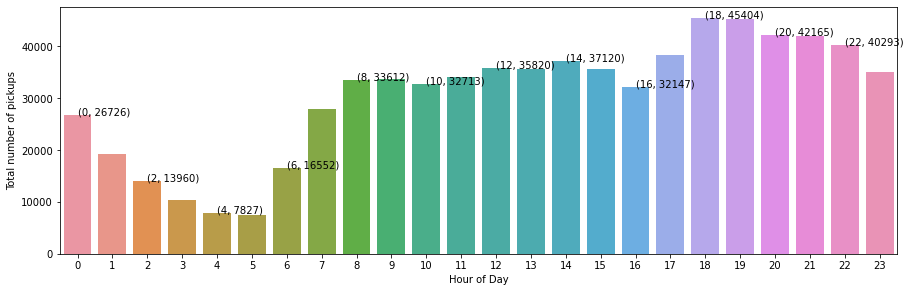

In [21]:
# Datetime features
plt.figure(figsize=(22, 6))

# Day_of_Week
plt.figure(figsize=(15,10))
plt.subplot(211)
sns.countplot(df['day_of_week'])
plt.xlabel('Week Day')
plt.ylabel('Total Number of pickups')
for i, j in enumerate(df['day_of_week'].value_counts().sort_index()):
    plt.text(i, j, '({}, {})'.format(i, j))
plt.show()

# Hour_of_Day
plt.figure(figsize=(15,10))
plt.subplot(212)
sns.countplot(df['hour_of_day'])
plt.xlabel('Hour of Day')
plt.ylabel('Total number of pickups')
for i, j in enumerate(df['hour_of_day'].value_counts().sort_index()):
    if (i%2 == 0):
        plt.text(i, j, '({}, {})'.format(i, j))
    elif (i == df['hour_of_day'].value_counts().sort_index().max()):
        plt.text(i, j, '({}, {})'.format(i, j))
    else:
        continue
plt.show()

* Number of pickups for Sundays is much lower than week days with a peak on **Friday (4)**. Note that here weekday is a decimal number, where **0 is Monday and 6 is Sunday**.
* Number of pickups as expected is highest in late evenings around **0600PM to 0700PM**. However, it is much lower during the morning peak hours.

### Lattitude & Longitude

Lets look at the geospatial or location features to check consistency. They should not vary much as we are only considering trips within New York city.

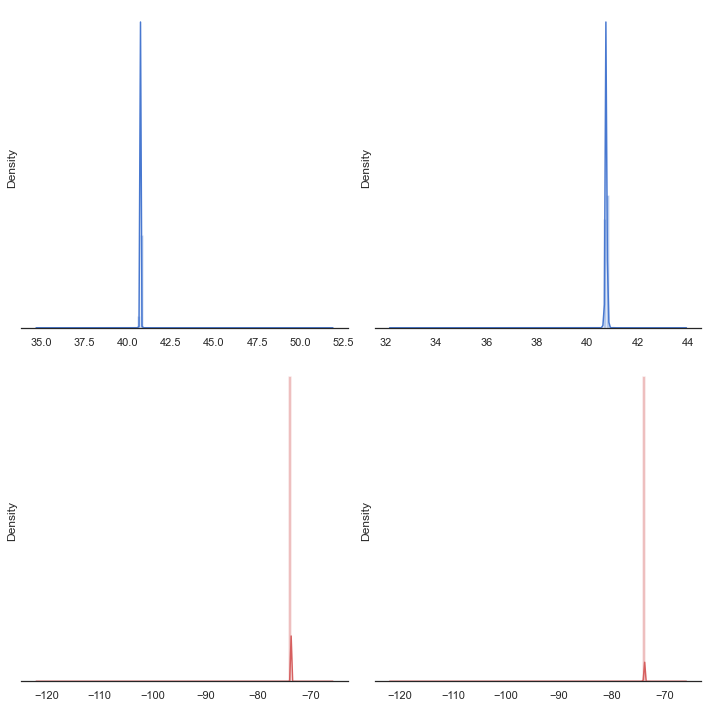

In [22]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(df['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(df['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[1,0])
sns.distplot(df['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[0,1])
sns.distplot(df['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1,1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

Findings - (Here, red represents pickup and dropoff Longitudes & blue represents pickup & dropoff lattitudes)

1. From the plot above it is clear that pick and drop latitude are centered around 40 to 41, and longitude are situated around -74 to -73. 
2. Some extreme co-ordinates has squeezed the plot such that we see a spike here
3. A good idea is to remove these outliers and look at the distribution more closely

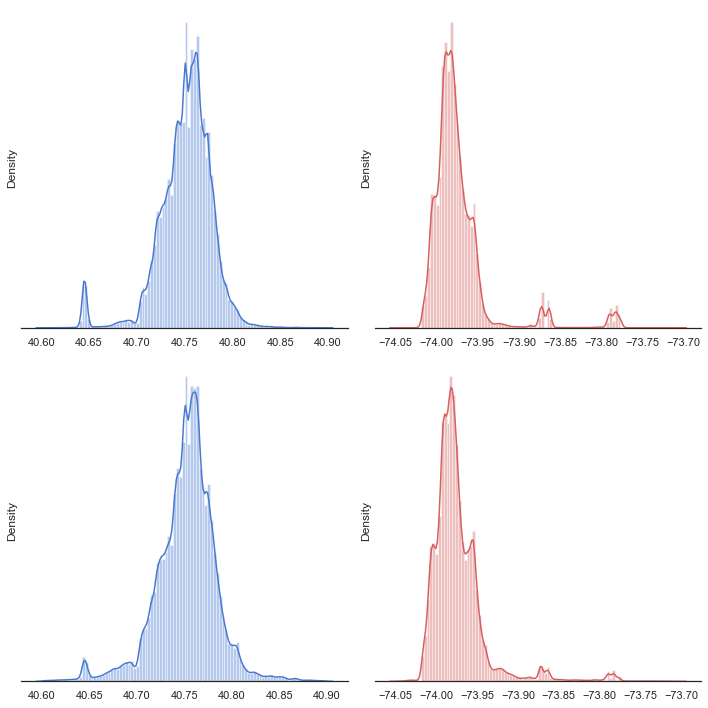

In [23]:
df = df.loc[(df.pickup_latitude > 40.6) & (df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
df_data_new = df.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)#
sns.despine(left=True)
sns.distplot(df_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(df_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[0,1])
sns.distplot(df_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[1, 0])
sns.distplot(df_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()

plt.show()

* We have a much better view of the distribution of coordinates instead of spikes. And we see that most trips are concentrated between these lat long only with a few significant clusters.
* These clusters are represented by the numerous peaks in the lattitude and longitude histograms


### Compute Trip Distance

In [24]:
pip install h3

Note: you may need to restart the kernel to use updated packages.


In [25]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [26]:
from geopy import distance
import h3

In [27]:
df.reset_index(inplace=True)
df=df.drop(['index'],axis=1)
df.tail()

id  vendor_id     pickup_datetime    dropoff_datetime  \
726190  id3905982          2 2016-05-21 13:29:38 2016-05-21 13:34:34   
726191  id0102861          1 2016-02-22 00:43:11 2016-02-22 00:48:26   
726192  id0439699          1 2016-04-15 18:56:48 2016-04-15 19:08:01   
726193  id2078912          1 2016-06-19 09:50:47 2016-06-19 09:58:14   
726194  id1053441          2 2016-01-01 17:24:16 2016-01-01 17:44:40   

        passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
726190                2        -73.965919        40.789780         -73.952637   
726191                1        -73.996666        40.737434         -74.001320   
726192                1        -73.997849        40.761696         -74.001488   
726193                1        -74.006706        40.708244         -74.013550   
726194                4        -74.003342        40.743839         -73.945847   

        dropoff_latitude  store_and_fwd_flag  trip_duration  \
726190         40.789181                   0            296   
726191         40.731911                   0            315   
726192         40.741207                   0            673   
726193         40.713814                   0            447   
726194         40.712841                   0           1224   

        check_trip_duration  log_trip_duration  month_of_year  day_of_week  \
726190                296.0           5.693732              5            5   
726191                315.0           5.755742              2            0   
726192                673.0           6.513230              4            4   
726193                447.0           6.104793              6            6   
726194               1224.0           7.110696              1            4   

        hour_of_day  
726190           13  
726191            0  
726192           18  
726193            9  
726194           17

In [28]:
# start_dist = dt.datetime.now()
# print("start dist:-", start_dist)

h3_dist=[]
geo_dist=[]

for i in range(len(df)):
    h3_= round(h3.point_dist((df['pickup_latitude'][i], df['pickup_longitude'][i]), (df['dropoff_latitude'][i], df['dropoff_longitude'][i]), unit='km'),2)
    geo_= round(distance.great_circle((df['pickup_latitude'][i], df['pickup_longitude'][i]), (df['dropoff_latitude'][i], df['dropoff_longitude'][i])).km,2)
    h3_dist.append(h3_)
    geo_dist.append(geo_)

# end_dist = dt.datetime.now()   
# print("end dist:-",end_dist)


In [29]:
df['distance'] = pd.DataFrame(data=h3_dist)
df['geo_distance'] = pd.DataFrame(data=geo_dist)

In [30]:
df.head()

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id1080784          2 2016-02-29 16:40:21 2016-02-29 16:47:01   
1  id0889885          1 2016-03-11 23:35:37 2016-03-11 23:53:57   
2  id0857912          2 2016-02-21 17:59:33 2016-02-21 18:26:48   
3  id3744273          2 2016-01-05 09:44:31 2016-01-05 10:03:32   
4  id0232939          1 2016-02-17 06:42:23 2016-02-17 06:56:31   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.953918        40.778873         -73.963875   
1                2        -73.988312        40.731743         -73.994751   
2                2        -73.997314        40.721458         -73.948029   
3                6        -73.961670        40.759720         -73.956779   
4                1        -74.017120        40.708469         -73.988182   

   dropoff_latitude  store_and_fwd_flag  trip_duration  check_trip_duration  \
0         40.771164                   0            400                400.0   
1         40.694931                   0           1100               1100.0   
2         40.774918                   0           1635               1635.0   
3         40.780628                   0           1141               1141.0   
4         40.740631                   0            848                848.0   

   log_trip_duration  month_of_year  day_of_week  hour_of_day  distance  \
0           5.993961              2            0           16      1.20   
1           7.003974              3            4           23      4.13   
2           7.400010              2            6           17      7.25   
3           7.040536              1            1            9      2.36   
4           6.744059              2            2            6      4.33   

   geo_distance  
0          1.20  
1          4.13  
2          7.25  
3          2.36  
4          4.33

In [31]:
df[df['trip_duration']>1000].tail()

id  vendor_id     pickup_datetime    dropoff_datetime  \
726181  id3477255          2 2016-01-20 08:22:38 2016-01-20 08:47:35   
726185  id3683137          2 2016-01-01 00:47:30 2016-01-01 01:12:56   
726186  id3993907          1 2016-02-05 11:24:34 2016-02-05 11:46:39   
726187  id3226129          2 2016-03-21 03:43:03 2016-03-21 04:05:21   
726194  id1053441          2 2016-01-01 17:24:16 2016-01-01 17:44:40   

        passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
726181                1        -73.977859        40.749538         -73.977859   
726185                1        -73.984779        40.779781         -73.998718   
726186                1        -73.994034        40.751015         -74.003738   
726187                2        -73.987740        40.748222         -73.949585   
726194                4        -74.003342        40.743839         -73.945847   

        dropoff_latitude  store_and_fwd_flag  trip_duration  \
726181         40.749538                   0           1497   
726185         40.739777                   0           1526   
726186         40.722240                   0           1325   
726187         40.680737                   0           1338   
726194         40.712841                   0           1224   

        check_trip_duration  log_trip_duration  month_of_year  day_of_week  \
726181               1497.0           7.311886              1            2   
726185               1526.0           7.331060              1            4   
726186               1325.0           7.189922              2            4   
726187               1338.0           7.199678              3            0   
726194               1224.0           7.110696              1            4   

        hour_of_day  distance  geo_distance  
726181            8      0.00          0.00  
726185            0      4.60          4.60  
726186           11      3.30          3.30  
726187            3      8.16          8.16  
726194           17      5.95          5.95

In [32]:
df['distance'].min(),df['distance'].max() 

(0.0, 33.07)

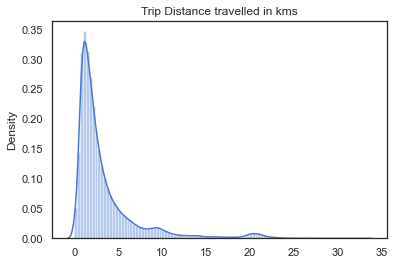

In [33]:
df = df.loc[(df.pickup_latitude > 40.6) & (df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
df_data_new = df.copy()
sns.set(style="white", palette="muted", color_codes=True)
sns.despine(left=True)
sns.distplot(df_data_new['distance'].values, label = 'distance',color="b",bins = 100)
plt.title("Trip Distance travelled in kms")
plt.show()

In [34]:
print("%.0d%%" % (100*(df_data_new[df_data_new['distance']<=5]['distance'].count()/len(df_data_new))))

82%


Most trips are completed within 5kms distance.

## 1.8 Bivariate Relations with Target
Now that we have gone through all the basic features one by one. Let us start looking at their relation with the target. This will help us in selecting and extracting features at the modelling stage.

In [35]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'check_trip_duration', 'log_trip_duration',
       'month_of_year', 'day_of_week', 'hour_of_day', 'distance',
       'geo_distance'],
      dtype='object')

### Trip Duration vs Month of Year

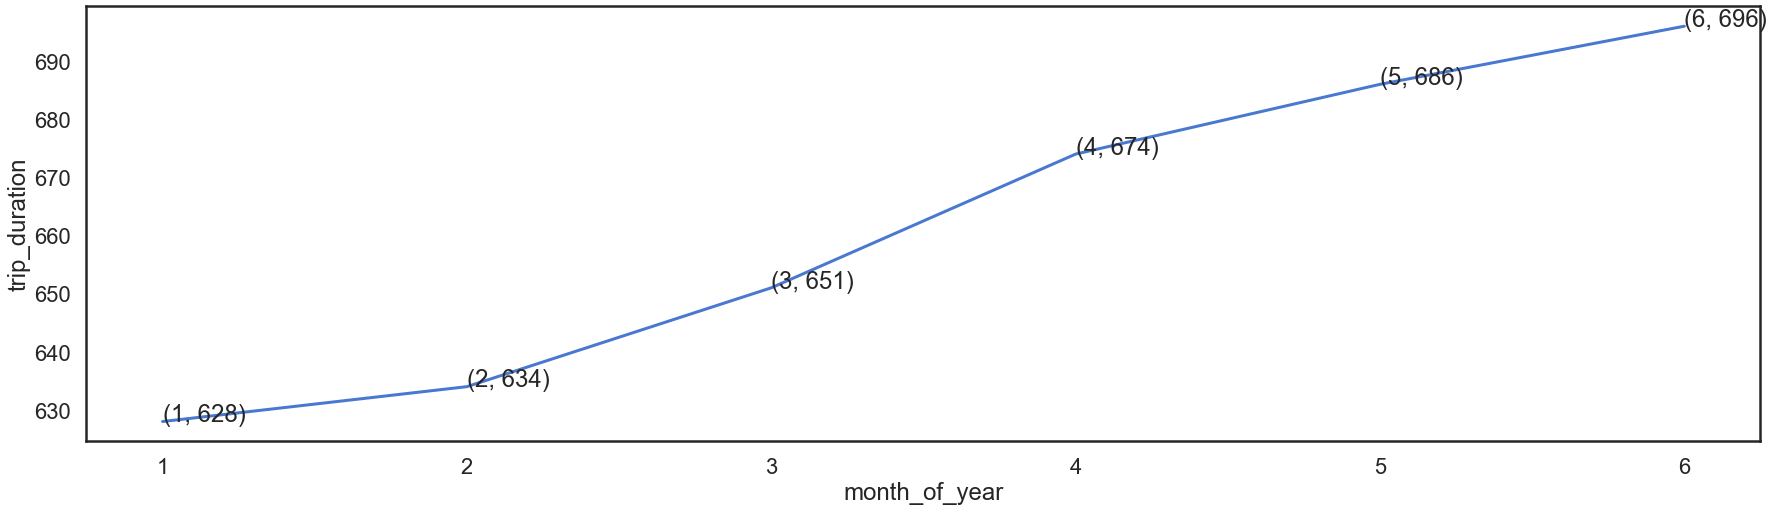

month_of_year  trip_duration  unit
0              1            628     1
1              2            634     1
2              3            651     1
3              4            674     1
4              5            686     1
5              6            696     1

In [36]:
summary_month_avg_duration = pd.DataFrame(df.groupby(['month_of_year'])['trip_duration'].median())
summary_month_avg_duration.reset_index(inplace = True)
summary_month_avg_duration['unit']=1

plt.figure(figsize=(30,8))
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(data=summary_month_avg_duration, x="month_of_year", y="trip_duration", markers=True)
for i, j in zip(summary_month_avg_duration['month_of_year'], summary_month_avg_duration['trip_duration']):
    plt.text(i, j, '({}, {})'.format(i, j))
plt.show()
summary_month_avg_duration

Trip duration over the months is consistent ranging from 10.5 minutes to 11.6 minutes.

### Trip Duration vs Weekday

For different week days, the trip durations can vary as different week days might have different traffic densities especially the weekends might have a much different patterns as compared to working days. Weekday is taken as a decimal number, where 0 - Sunday and 6 is Saturday.

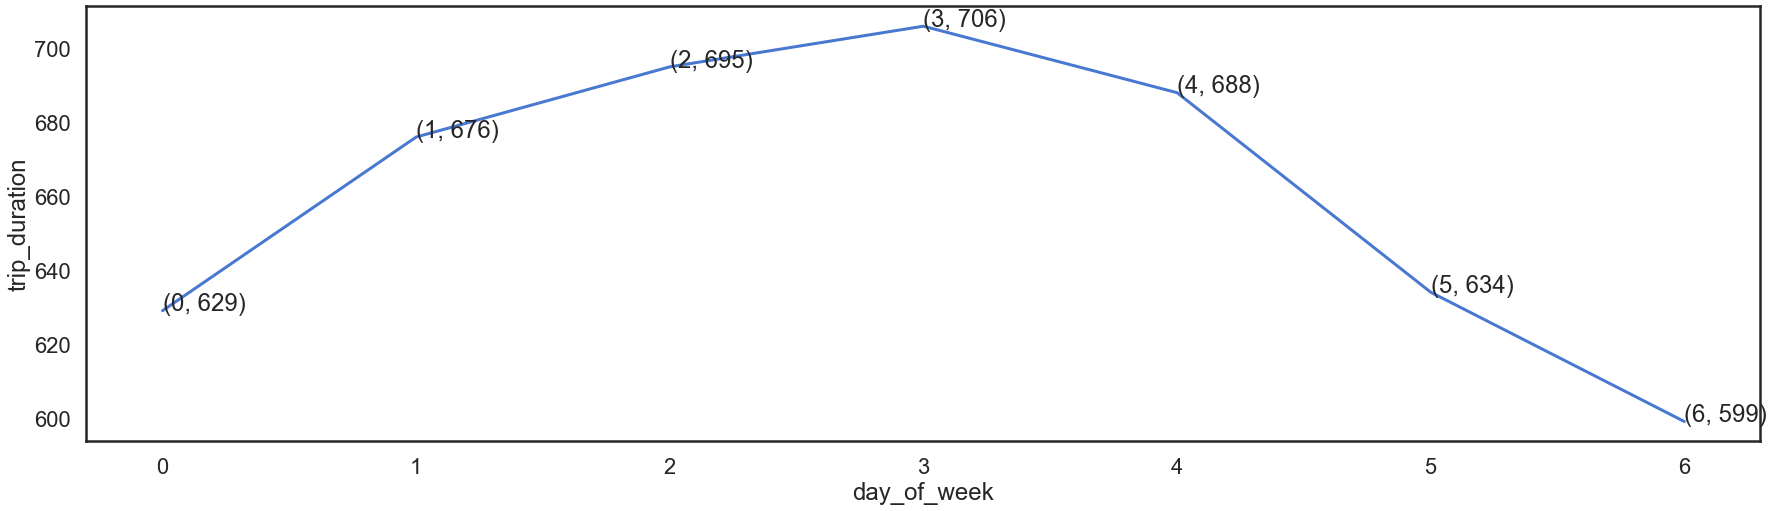

In [37]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['day_of_week'])['trip_duration'].median())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

plt.figure(figsize=(30,8))
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(data=summary_wdays_avg_duration, x="day_of_week", y="trip_duration", markers=True)
for i, j in zip(summary_wdays_avg_duration['day_of_week'], summary_wdays_avg_duration['trip_duration']):
    plt.text(i, j, '({}, {})'.format(i, j))
plt.show()

In [38]:
summary_wdays_avg_duration 
# len(summary_wdays_avg_duration)
# sns.lineplot()
# summary_hourly_avg_duration['trip_duration'].min()

day_of_week  trip_duration  unit
0            0            629     1
1            1            676     1
2            2            695     1
3            3            706     1
4            4            688     1
5            5            634     1
6            6            599     1

## Trip Duration vs Hour of the Day

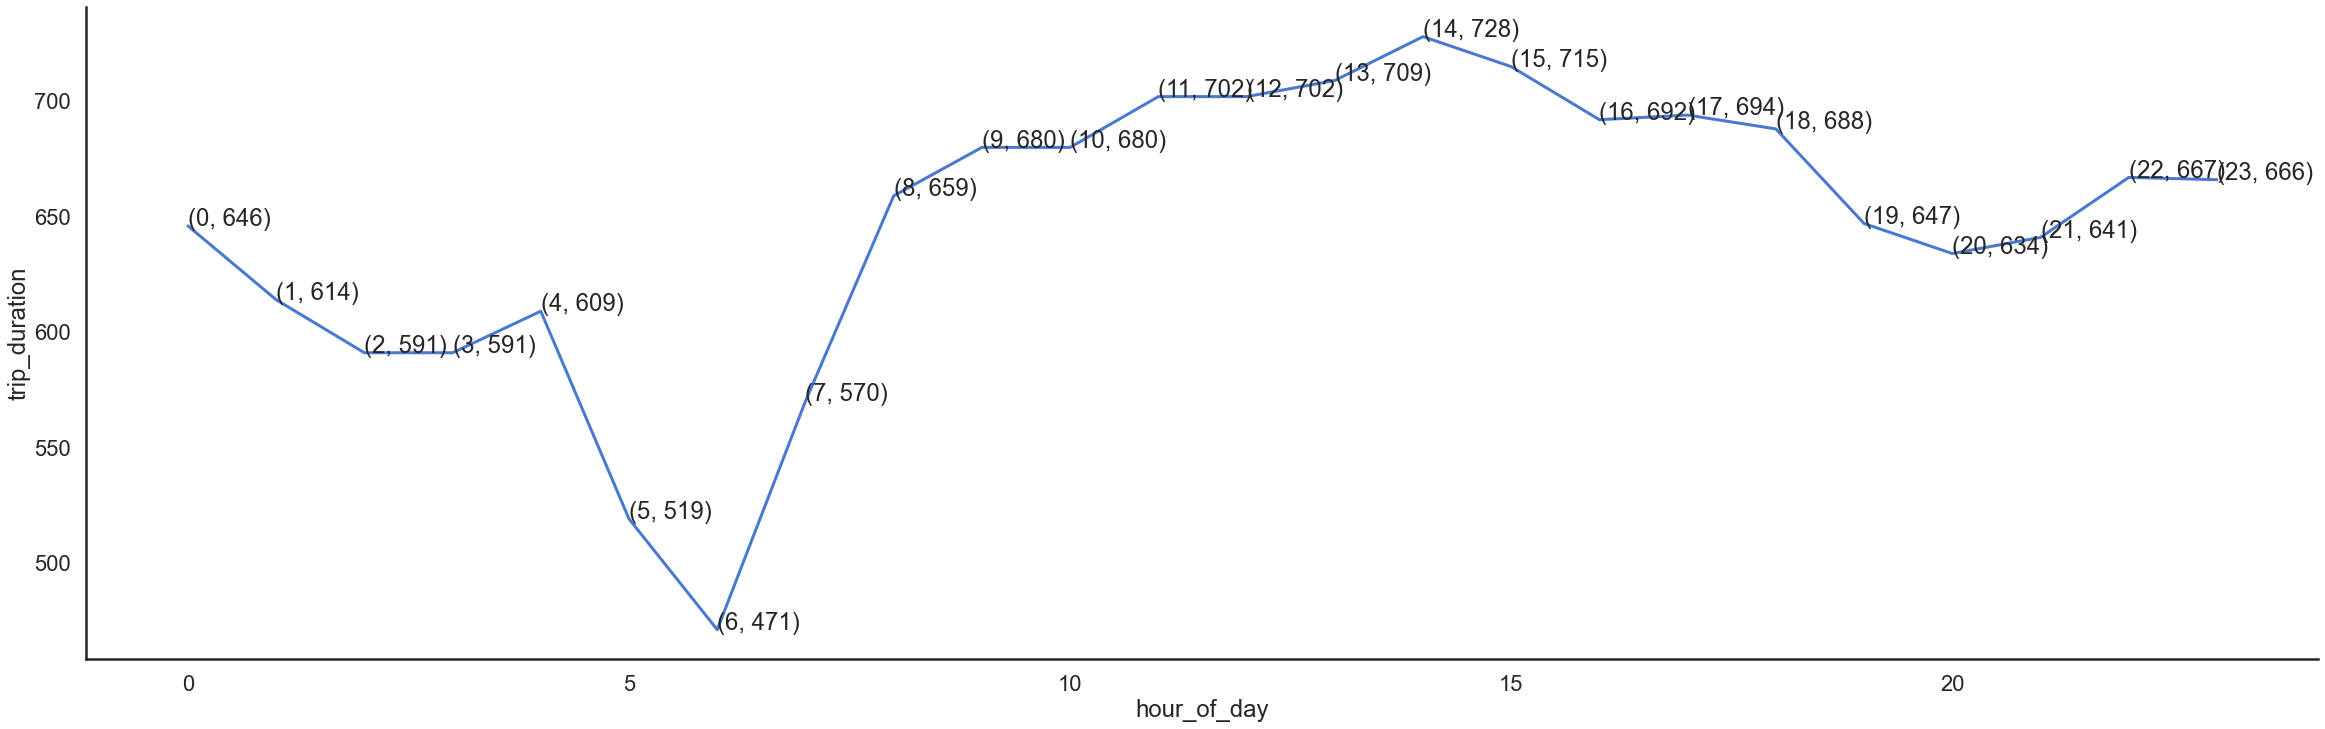

In [39]:

summary_hourly_avg_duration = pd.DataFrame(df.groupby(['hour_of_day'])['trip_duration'].median())
summary_hourly_avg_duration.reset_index(inplace = True)
summary_hourly_avg_duration['unit']=1
summary_hourly_avg_duration['trip_duration']= summary_hourly_avg_duration['trip_duration'].astype('int64')

plt.figure(figsize=(40,12))
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(data=summary_hourly_avg_duration, x="hour_of_day", y="trip_duration")
sns.despine(bottom = False)
for i, j in zip(summary_hourly_avg_duration['hour_of_day'], summary_hourly_avg_duration['trip_duration']):
    plt.text(i, j, '({}, {})'.format(i, j))
plt.show()


* Trip durations are definitely shorter for later at night and early morning hours that can be attributed to low traffic density
* It follows a similar pattern when compared to number of pickups indicating a correlation between number of pickups and trip duration

### vendor_id vs Trip Duration

Let's check how the trip duration varies for different vendors.

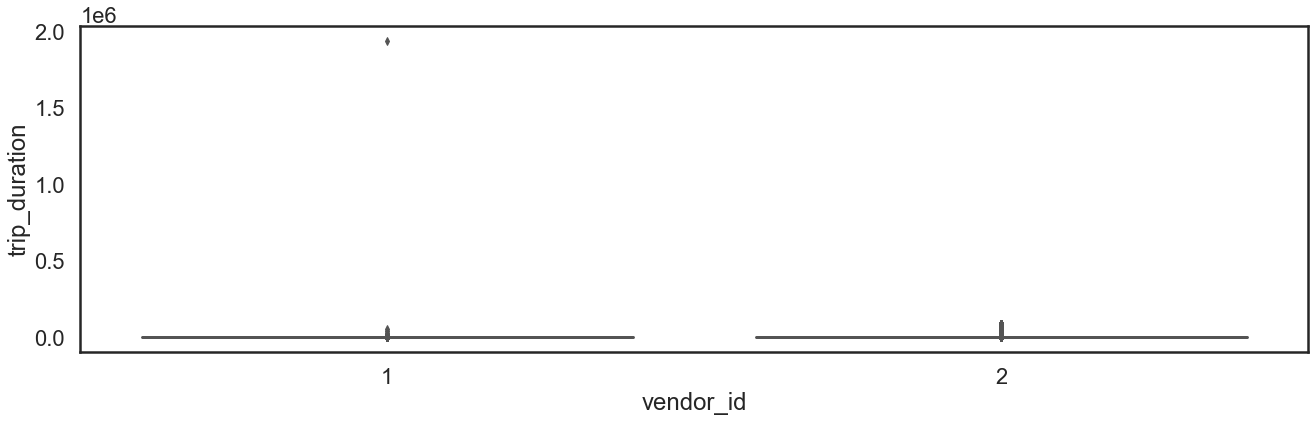

In [40]:
plt.figure(figsize=(22, 6))
sns.boxplot(x="vendor_id", y="trip_duration", data=df)
plt.show()

Woah! This did not came out as expected. The only thing I can see from this boxplot is that for vendor 1, there are a number of outliers exceeding 24 hours while vendor 2 does not have such long trips.

There could be 2 solutions to this:
1. Remove the huge outliers and plot again 
2. Look at median trip duration for both vendors on hourly basis

Let's try the first technique now and check trips below 50000 seconds only

In [41]:
pd.DataFrame(df.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())

trip_duration
vendor_id day_of_week               
1         0               796.759963
          1               884.397847
          2               870.338444
          3               881.725656
          4               857.776237
          5               771.325599
          6               750.181296
2         0               965.796987
          1              1053.822405
          2              1059.235157
          3              1102.769141
          4              1093.896596
          5              1027.232217
          6              1005.868985

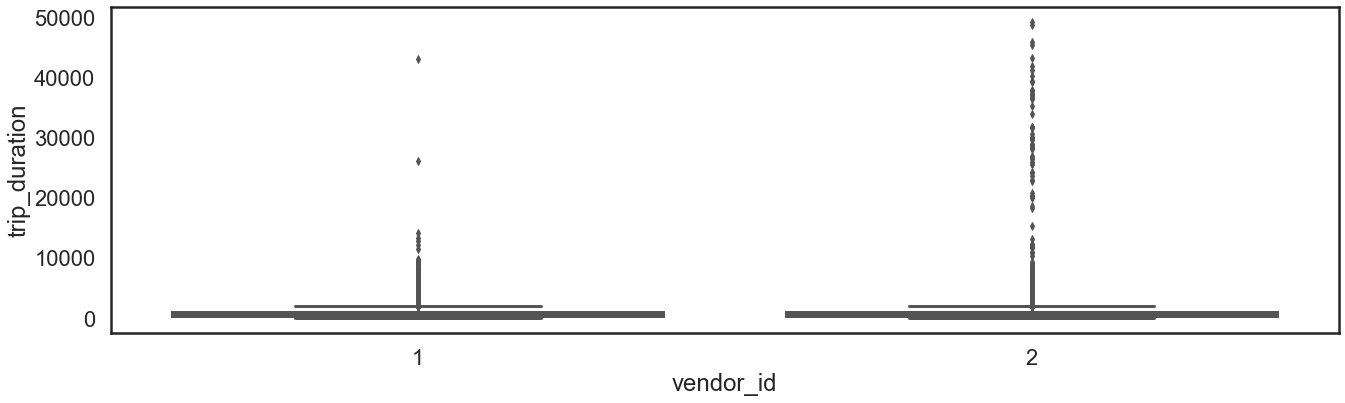

In [42]:
plt.figure(figsize=(22, 6))
df_sub = df[df['trip_duration'] < 50000]
sns.boxplot(x="vendor_id", y="trip_duration", data=df_sub)
plt.show()

As you can see, we were in a false perception earlier that vendor 1 had more outliers. Since the median is just around 600 seconds, we observe that vendor 2 has many more outliers as compared to vendor 1. Next, to confirm this, we will quickly look at the mean wrt day of week for both vendors using tsplot (time series plot) from seaborn.

### Mean Trip Duration Vendor Wise

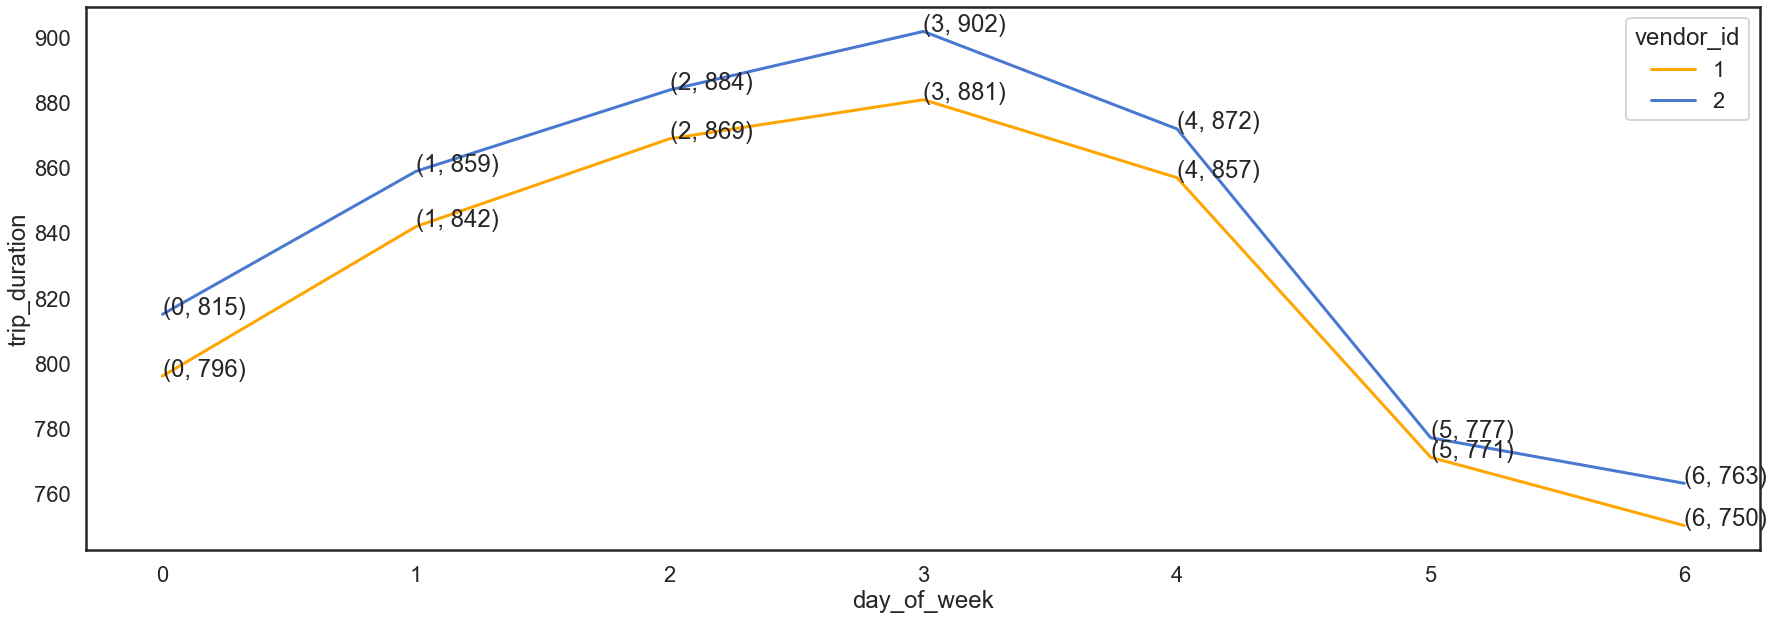

In [43]:
summary_wdays_avg_duration = pd.DataFrame(df_sub.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
summary_wdays_avg_duration['trip_duration']= summary_wdays_avg_duration['trip_duration'].astype('int64')

plt.figure(figsize = (30,10))
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(data=summary_wdays_avg_duration, x="day_of_week", hue="vendor_id", y="trip_duration", palette=['orange', 'b'])
for i, j in zip(summary_wdays_avg_duration['day_of_week'],summary_wdays_avg_duration['trip_duration']):
    plt.text(i, j, '({}, {})'.format(i, j))
plt.show()


### Median Trip Duration Vendor Wise

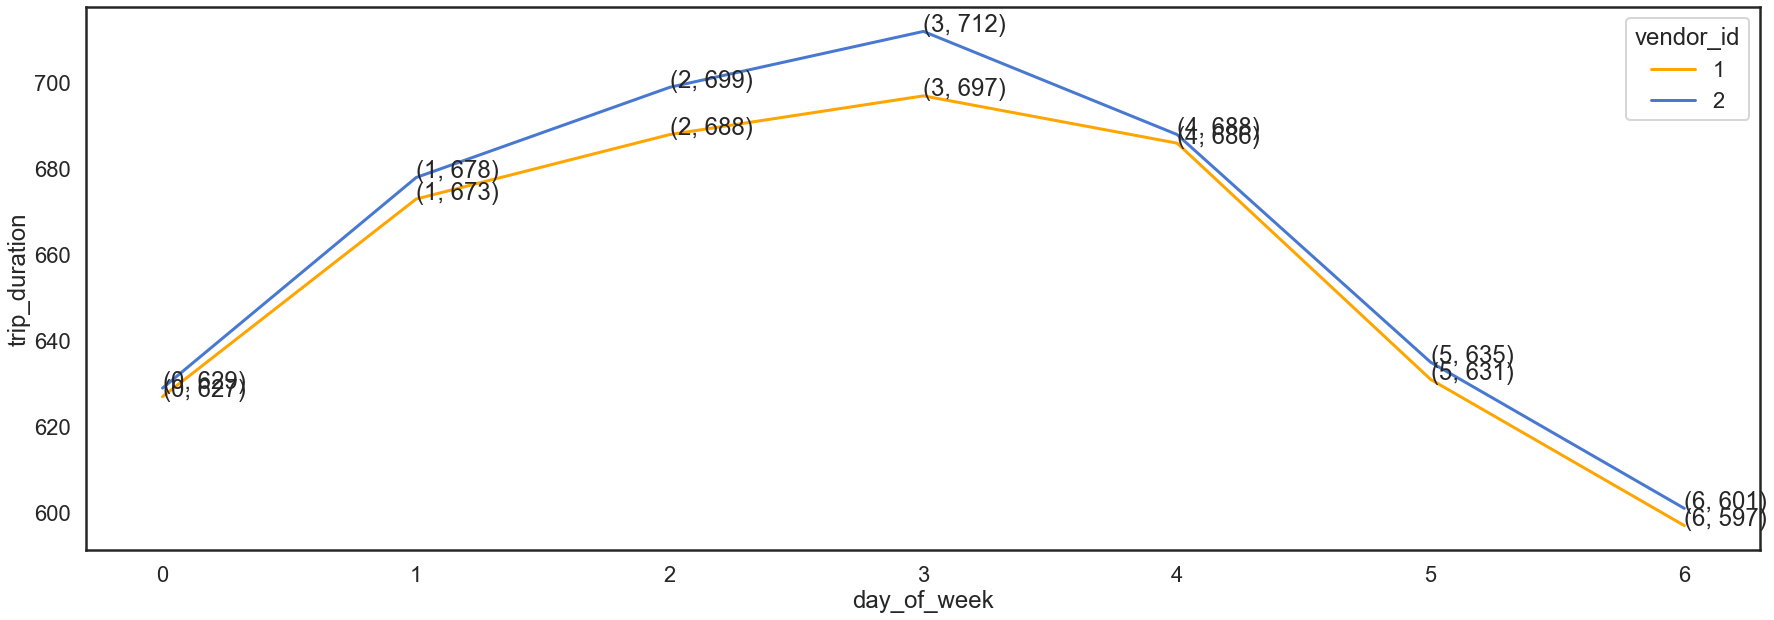

In [44]:
summary_wdays_avg_duration = pd.DataFrame(df_sub.groupby(['vendor_id','day_of_week'])['trip_duration'].median())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
summary_wdays_avg_duration['trip_duration']= summary_wdays_avg_duration['trip_duration'].astype('int64')

plt.figure(figsize = (30,10))
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(data=summary_wdays_avg_duration, x="day_of_week", hue="vendor_id", y="trip_duration", palette=['orange', 'b'])
for i, j in zip(summary_wdays_avg_duration['day_of_week'],summary_wdays_avg_duration['trip_duration']):
    plt.text(i, j, '({}, {})'.format(i, j))
plt.show()


Median trip duration does not vary much as can be seen from the above plot for different vendors. It emphasises the importance of looking at the correct measure for central tendency for analysis.

### Trip Duration vs Passenger Count

Again as we are aware, there are a large number of outliers for trip duration and we will not be able to observe the differences. For this, we have taken a cutoff of 10000 seconds and used a boxplot.

In [45]:
df.passenger_count.value_counts().sort_index()

0        31
1    515243
2    104576
3     29561
4     13972
5     38776
6     24035
9         1
Name: passenger_count, dtype: int64

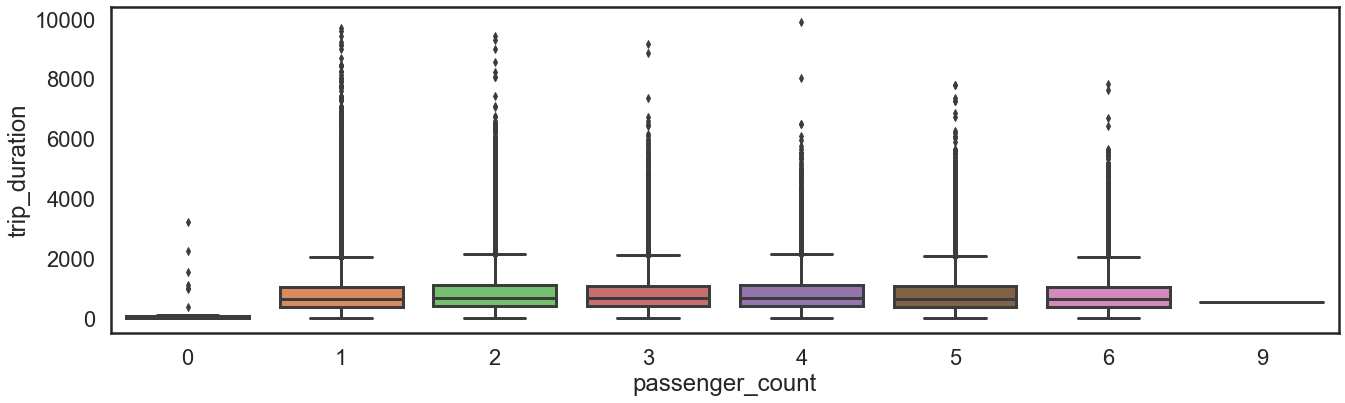

In [46]:
df.passenger_count.value_counts()
plt.figure(figsize=(22, 6))
df_sub = df[df['trip_duration'] < 10000]
sns.boxplot(x="passenger_count", y="trip_duration", data=df_sub)
plt.show()



* The boxplot clearly shows that there not much of a difference in distribution for the most frequently occuring passenger count values - 1, 2, 3.
* Another key observation is that the number of outliers are reduced for higher passenger counts but that only comes down to the individual frequencies of each passenger count.

### Visualise most frequently occuring Pickup points on the lattitude-longitude Map

Here, we try to visualise the most frequently occuring pickup points on the map and check how it is distributed spatially.

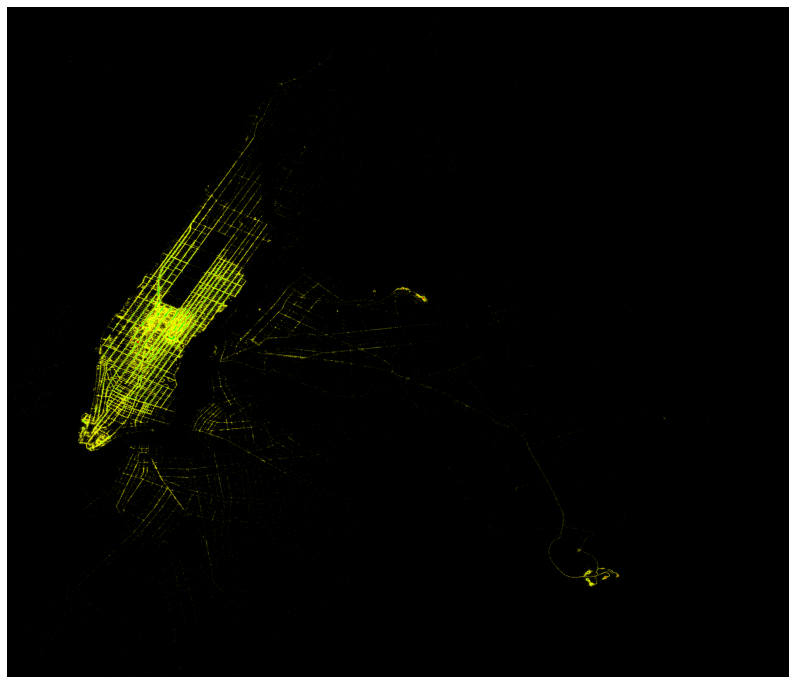

In [47]:

rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
rgb[..., 0] = 0
rgb[..., 1] = 0
rgb[..., 2] = 0
df_data_new['pick_lat_new'] = list(map(int, (-1*(df['pickup_latitude'] - (40.6000)))*10000))
df_data_new['drop_lat_new'] = list(map(int, (df['dropoff_latitude'] - (40.6000))*10000))
df_data_new['pick_lon_new'] = list(map(int, (df['pickup_longitude'] - (-74.050))*10000))
df_data_new['drop_lon_new'] = list(map(int,(df['dropoff_longitude'] - (-74.050))*10000))

summary_plot = pd.DataFrame(df_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

summary_plot.reset_index(inplace = True)
# summary_plot.head(120)

lat_list = summary_plot['pick_lat_new'].unique()
for i in lat_list:
    lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
    unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
    for j in lon_list:
        a = unit[lon_list.index(j)]
        if (a//25) >0:
            rgb[i][j][0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 0
        elif (a//10)>0:
            rgb[i,j, 0] = 0
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
        else:
            rgb[i,j, 0] = 255
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
ax.imshow(rgb, cmap = 'hot')
ax.set_axis_off() 

In [48]:
summary_plot.head()

pick_lat_new  pick_lon_new  id
0         -2994          2501   1
1         -2967          1794   1
2         -2964          1780   1
3         -2963          1654   1
4         -2961          1872   1

In [49]:
summary_plot[summary_plot['id']<=10]['id'].count(),summary_plot[summary_plot['id']<=10]['id'].sum()

(146828, 404407)

In [50]:
summary_plot[(summary_plot['id']>10) & (summary_plot['id']<25)]['id'].count(),summary_plot[(summary_plot['id']>10) & (summary_plot['id']<25)]['id'].sum()

(14196, 214619)

In [51]:
summary_plot[summary_plot['id']>=25]['id'].count(),summary_plot[summary_plot['id']>=25]['id'].sum()

(2567, 107169)

Findings - From the heatmap kind of image above -

* yellow points - 1-10 trips have yellow as pickup point
* Green points - 10-25 trips have green as pickup point
* Red points - More than 25 trips have red as pickup point

As expected there are a few small clusters for hot pickup points as displayed by red in the above plot. Most pickup points have less than 10 trips and distributed all over the city.

If you go and have a look at an actual map of New York City, red and green points are mostly concentrated around the Manhatten Area

Text(0.5, 1.0, 'NYC City Trips')

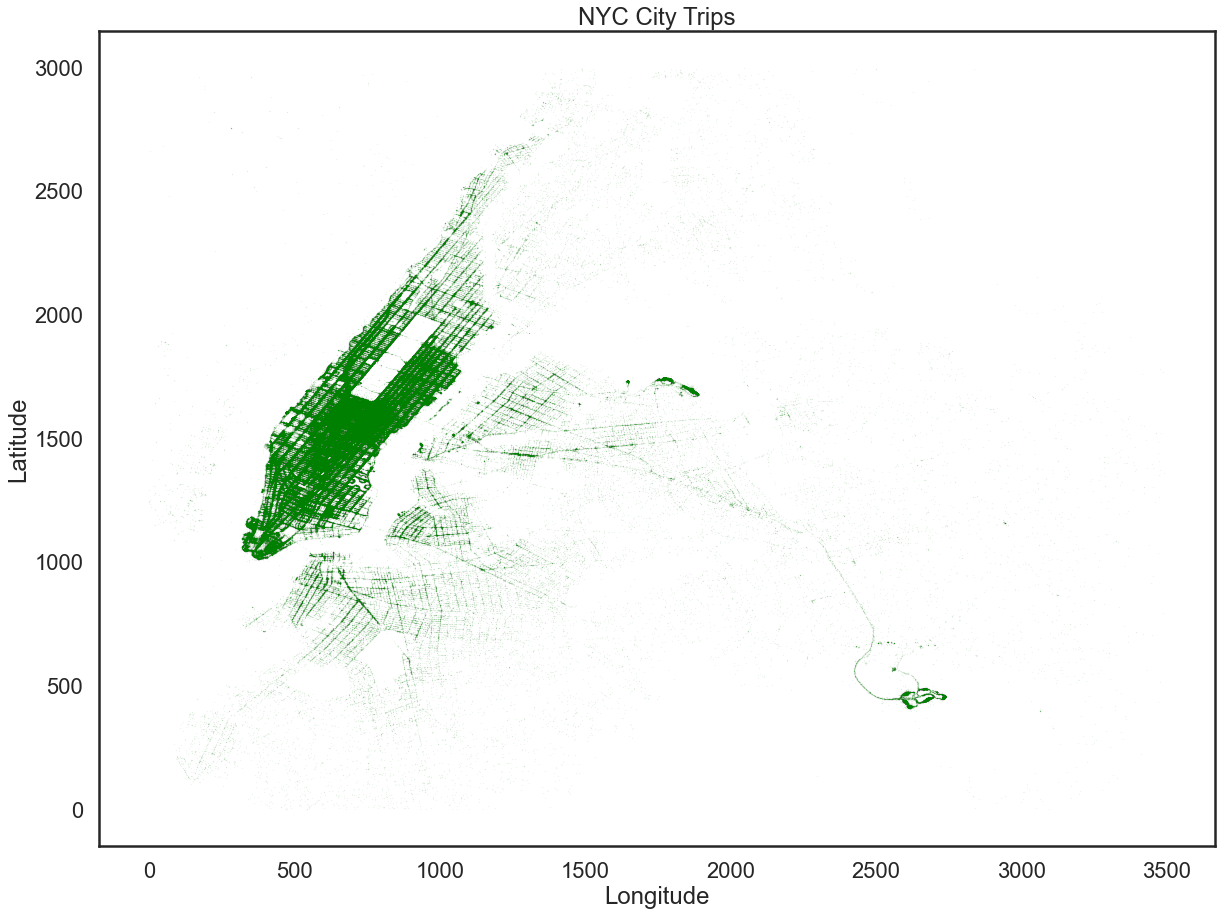

In [52]:
# Plot Latitude and Longitude
plt.figure(figsize=(20,15))

# Pickup and Dropoff values in a list for Latitudes and Longitudes 
longitudes = list(df_data_new.pick_lon_new) + list(df_data_new.drop_lon_new)
latitudes = list(-1*(df_data_new.pick_lat_new)) + list(df_data_new.drop_lat_new)

# Plot latitude and Longitude
plt.plot(longitudes, latitudes, '.', alpha=1, markersize=0.05, color='green')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('NYC City Trips')

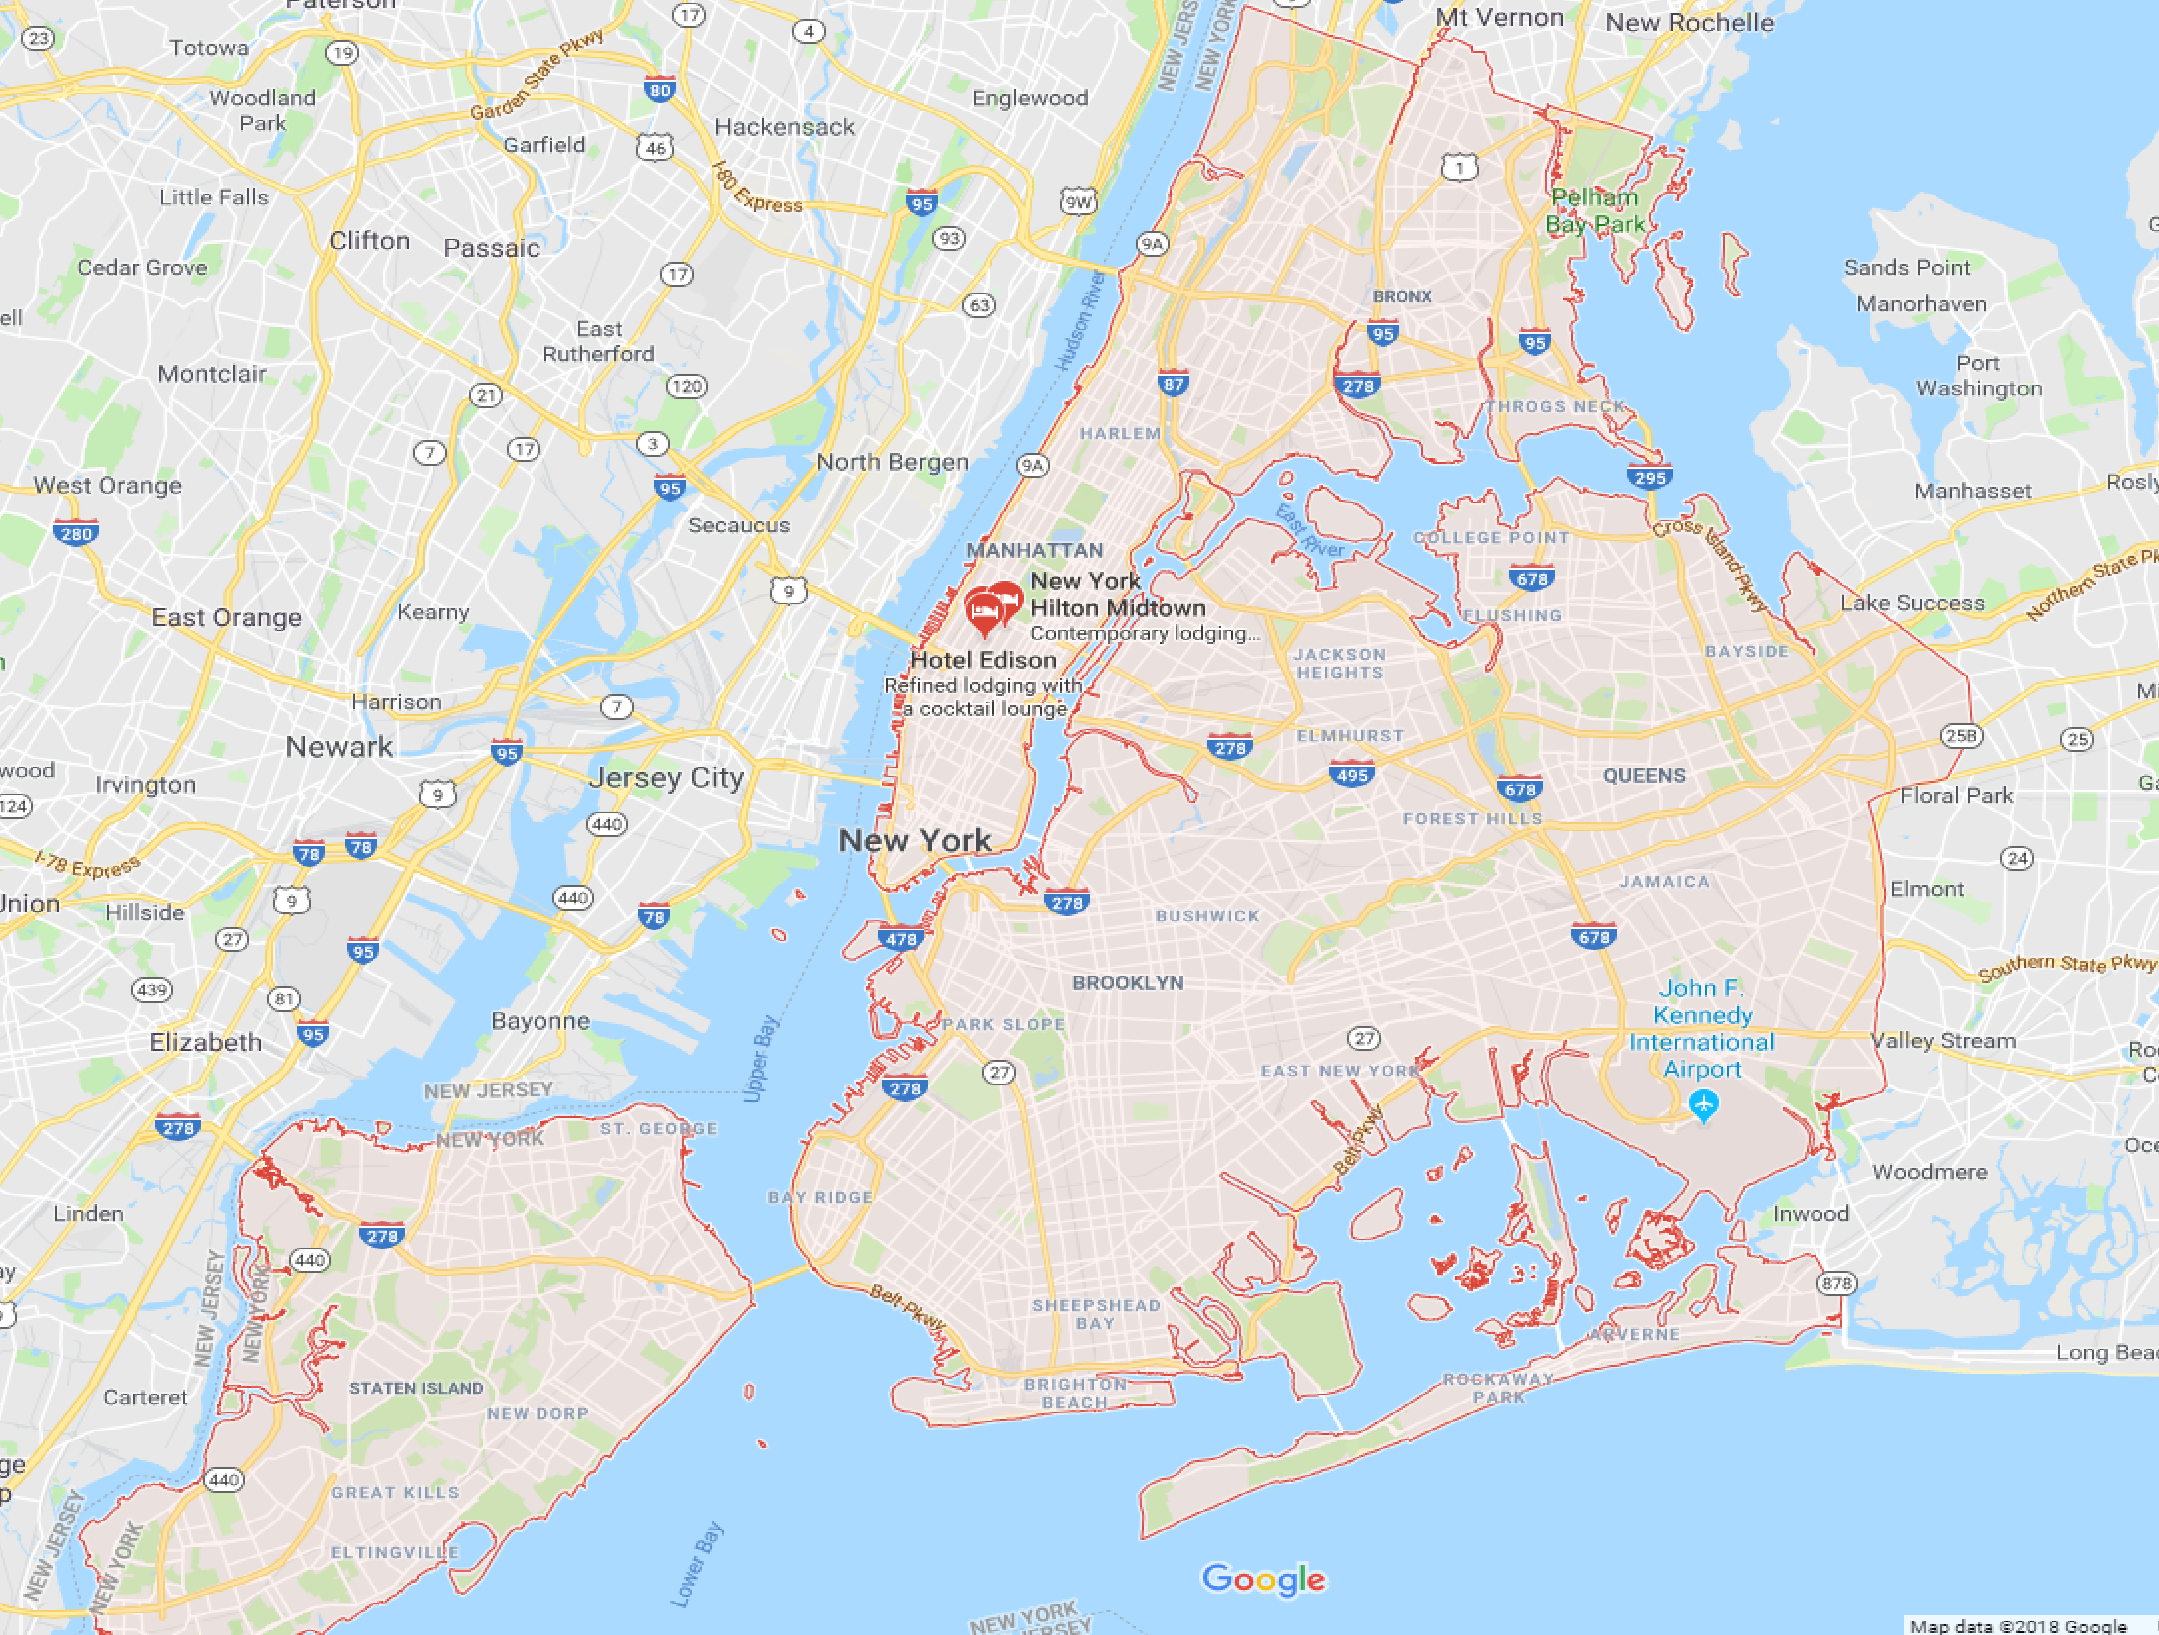

In [53]:
# Import image
from IPython.display import Image

# Load and Display Image of NYC
Image('EDA_NYC_Taxi (1)/nyc.png')

### Trip Duration vs Distance

In [54]:
df['distance_']=df['distance'].astype('int64')

In [55]:
df['distance_'].unique()

array([ 1,  4,  7,  2,  3,  9,  6,  0,  5, 10, 21, 20, 13, 17, 22,  8, 19,
       27, 16, 11, 14, 12, 18, 24, 15, 23, 25, 26, 28, 29, 31, 30, 33],
      dtype=int64)

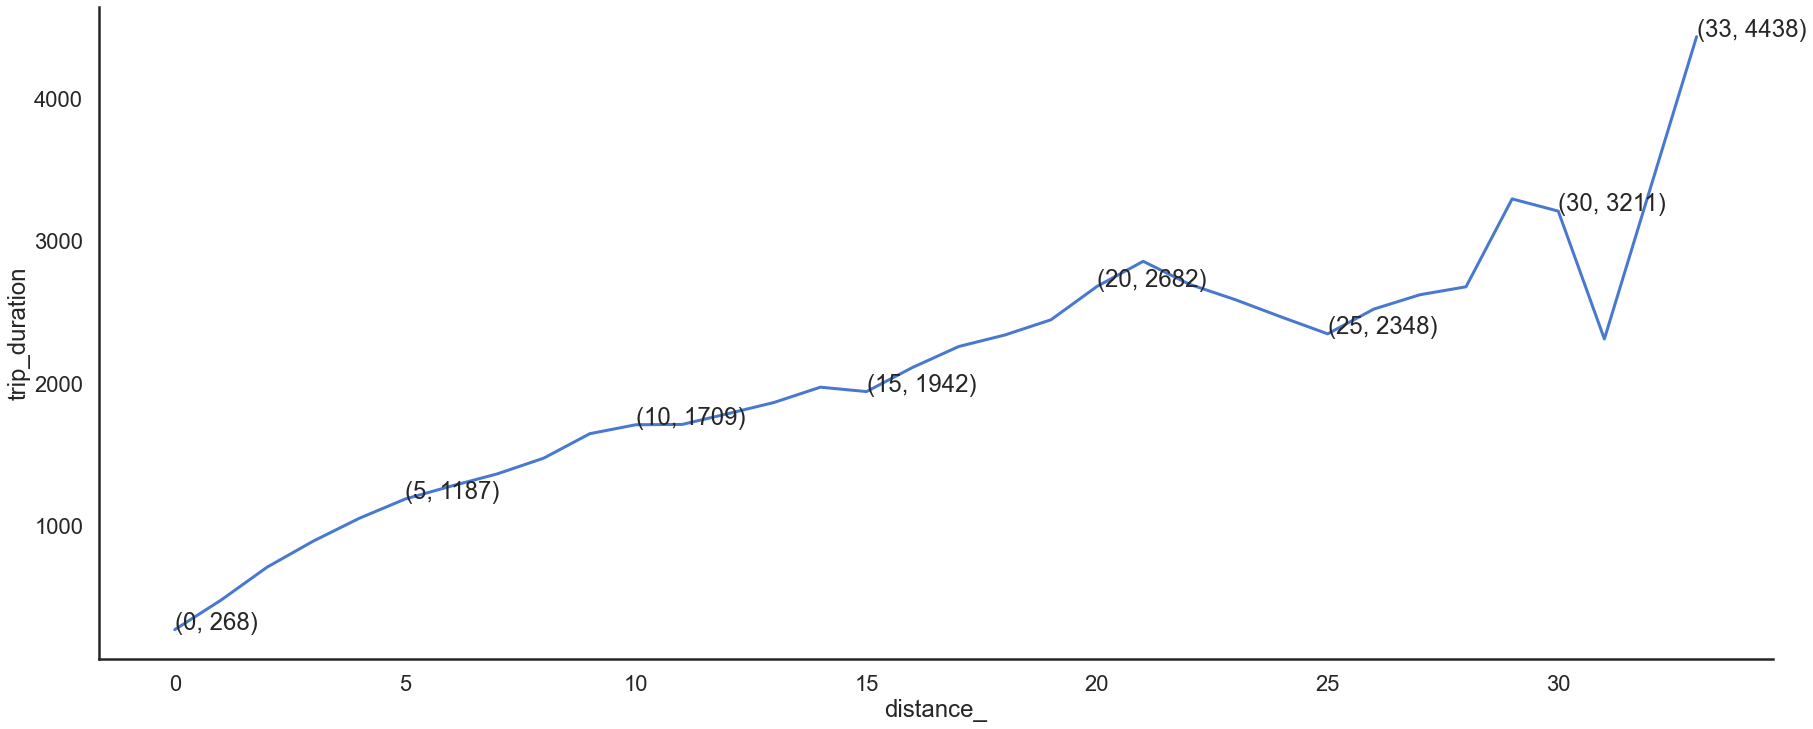

In [56]:

summary_distance_avg_duration = pd.DataFrame(df.groupby(['distance_'])['trip_duration'].median())
summary_distance_avg_duration.reset_index(inplace = True)
summary_distance_avg_duration['unit']=1
summary_distance_avg_duration['trip_duration']= summary_distance_avg_duration['trip_duration'].astype('int64')

plt.figure(figsize=(30,12))
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(data=summary_distance_avg_duration, x="distance_", y="trip_duration")
sns.despine(bottom = False)
for i, j in zip(summary_distance_avg_duration['distance_'], summary_distance_avg_duration['trip_duration']):
    if (i==0):
        plt.text(i, j, '({}, {})'.format(i, j))
    elif (i%5==0):
        plt.text(i, j, '({}, {})'.format(i, j))
    elif (i==summary_distance_avg_duration['distance_'].max()):
        plt.text(i, j, '({}, {})'.format(i, j))
    else:
        continue
plt.show()


We here observe that with increasing distance, there is increase in trip duration.
distance_ is in kms and trip_duration in seconds.

In [57]:
summary_distance_avg_duration.head()

distance_  trip_duration  unit
0          0            268     1
1          1            475     1
2          2            707     1
3          3            890     1
4          4           1051     1

## 1.9 Correlation Heatmap

Let us quickly look at the correlation heatmap to check the correlations amongst all features.

In [58]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'check_trip_duration', 'log_trip_duration',
       'month_of_year', 'day_of_week', 'hour_of_day', 'distance',
       'geo_distance', 'distance_'],
      dtype='object')

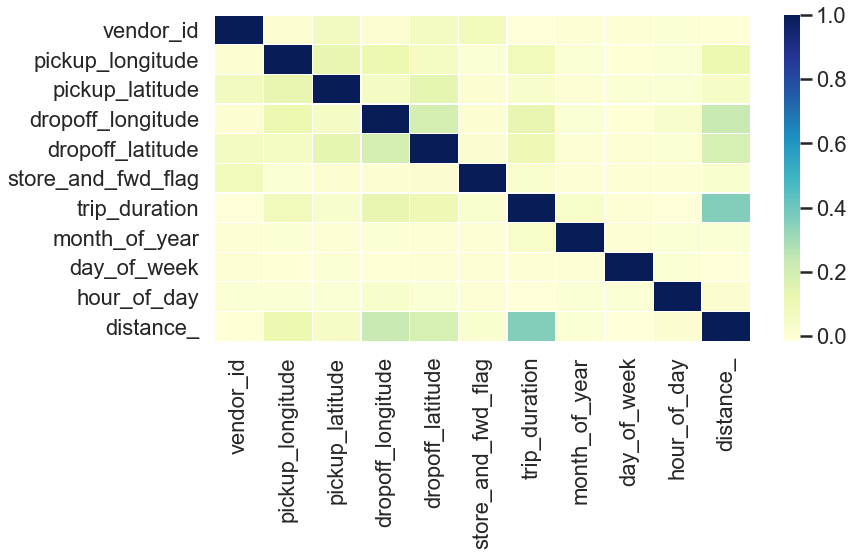

In [59]:
plt.figure(figsize=(12, 6))

df = df.drop(['id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count','check_trip_duration','log_trip_duration','distance','geo_distance'],
        axis=1)
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

### Conclusions
1. The majority of rides follow a rather smooth distribution that looks almost log-normal with a peak just around exp(6.5)  i.e. about **11 minutes**.
2. There are several suspiciously short rides with less than **10 seconds** duration.
3. As discussed earlier, there are a few huge outliers near 12.
4. Most of the trips involve only **1 passenger**. There are trips with 7-9 passengers but they are very low in number.
5. **Vendor 2** has more **number of trips** as compared to vendor 1
6. These trips are for **first 6 months of 2016**. There is MoM decline in number of pickups possibly due to drop in market share. 
7. Trip duration over the months is consistent ranging from **10.5 minutes to 11.6 minutes**.
8. **Number of pickups** for weekends is much lower than **week days with a peak on Friday (4)**. Note that here weekday is a decimal number, where 0 is Monday and 6 is Sunday.
9. Number of pickups as expected is **highest in evenings**. However, it is much **lower during the morning peak hours**.
10. We see that most trips are concentrated between these lat long only with a few significant clusters. These **clusters** are represented by the numerous peaks in the **lattitude and longitude** histograms
11. **Trip durations** are definitely **shorter for late night and early morning hours** that can be attributed to low traffic density
12. It follows a similar pattern when compared to **number of pickups** indicating a correlation between number of pickups and trip duration
13. Median trip duration does not vary much as can be seen from the above plot **for different vendors**.
14. The boxplot clearly shows that there **not much of a difference** in distribution for the most frequently occuring **passenger count values - 1, 2, 3**.
15. Another key observation is that the number of outliers are reduced for higher passenger counts but that only comes down to the individual frequencies of each passenger count.
16. From the correlation heatmap we see that the **lattitude and longitude features have higher correlation with the target** as compared to the other features.
17. The heatmap shows that **distance** between the pickup and dropoff point has **considerably high correlation** with the trip duration. **Most trips** covered are **under 5kms**.

# 2. Benchmark Model

## 2.1 Shuffle and Split the Dataset to Train and Test Set

In [60]:
df.shape

(726195, 11)

In [61]:
from sklearn.utils import shuffle

# Shuffle the Dataset
df = shuffle(df, random_state = 42)
df.reset_index(inplace=True)
df=df.drop(['index'],axis=1)

# Create 4 divisions
div = int(df.shape[0]/4)

# Train:Test = 3:4
train = df.loc[0:3*(div),:]
test = df.loc[3*(div)+1:,:]
div, train.shape, test.shape

(181548, (544645, 11), (181550, 11))

In [62]:
train.head()

vendor_id  pickup_longitude  pickup_latitude  dropoff_longitude  \
0          2        -73.985313        40.718601         -73.961151   
1          1        -73.982719        40.754265         -73.973457   
2          2        -73.978203        40.752541         -73.983177   
3          2        -73.975250        40.787827         -73.950958   
4          2        -73.862511        40.768929         -73.959373   

   dropoff_latitude  store_and_fwd_flag  trip_duration  month_of_year  \
0         40.661198                   0           2160              1   
1         40.752434                   0            295              6   
2         40.756199                   0            237              6   
3         40.814068                   0            717              2   
4         40.766781                   0           1076              2   

   day_of_week  hour_of_day  distance_  
0            4           23          6  
1            3            9          0  
2            5           15          0  
3            1           16          3  
4            0           22          8

In [63]:
test.head()

vendor_id  pickup_longitude  pickup_latitude  dropoff_longitude  \
544645          2        -73.990662        40.755859         -74.005440   
544646          2        -74.001228        40.741638         -74.002983   
544647          1        -73.992012        40.721848         -73.964851   
544648          2        -74.016022        40.714520         -74.005501   
544649          1        -73.974525        40.759766         -73.979729   

        dropoff_latitude  store_and_fwd_flag  trip_duration  month_of_year  \
544645         40.749851                   0            566              2   
544646         40.749413                   0            244              5   
544647         40.763279                   0            773              6   
544648         40.709370                   0            851              1   
544649         40.771454                   0            653              2   

        day_of_week  hour_of_day  distance_  
544645            1           10          1  
544646            3           16          0  
544647            6            3          5  
544648            3           12          1  
544649            1           13          1

## 2.2 Simple Mean Model

In [64]:
# Simple Mean
test['simple_mean'] = train['trip_duration'].mean()
print("Test simple mean",round(test['simple_mean'].mean(),2) )

Test simple mean 943.02


## 2.3 Selecting Evaluation Metric

In [65]:
# Mean Absolute Error
from sklearn.metrics import mean_absolute_error as MAE

test_MAE = MAE(test['trip_duration'] , test['simple_mean'])
print("Test score:",round(test_MAE,2))

Test score: 620.96


In [66]:
# Mean Squared Error
from sklearn.metrics import mean_squared_error as MSE

test_MSE = MSE(test['trip_duration'] , test['simple_mean'])
print("Test score:",round(test_MSE,2))

Test score: 30677041.54


In [67]:
# Root Mean Squared Error
from sklearn.metrics import mean_squared_error as MSE

train['simple_mean'] = train['trip_duration'].mean()
train_RMSE = int(MSE(train['trip_duration'] , train['simple_mean']))**0.5
test_RMSE = int(MSE(test['trip_duration'] , test['simple_mean']))**0.5
print("Train score:",int(train_RMSE), ";","Test score:",int(test_RMSE))

Train score: 3112 ; Test score: 5538


In [68]:
RMSE_score = pd.DataFrame({'train_score':int(train_RMSE), 'test_score':int(test_RMSE)}, 
                          index=[""])
RMSE_score

train_score  test_score
         3112        5538

Train score: 3112 ; Test score: 5538
Test score worse than Train score by  2426


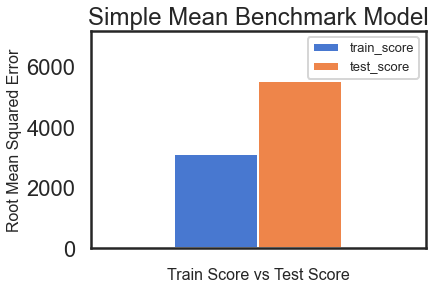

In [69]:
# plt.figure(figsize = (50,5))
RMSE_score.plot(kind='bar')

print("Train score:",int(train_RMSE), ";","Test score:",int(test_RMSE))

error = (test_RMSE)-(train_RMSE)
if error>0:
    print("Test score worse than Train score by ",int(error))

plt.title('Simple Mean Benchmark Model')    
plt.ylabel('Root Mean Squared Error', fontsize = 16)
plt.xlabel('Train Score vs Test Score', fontsize = 16)
plt.ylim(0,max(RMSE_score['test_score'])*1.3)
plt.legend(loc='upper right', fontsize = 13)

Selecting **RMSE** as Evaluation Metric to have high error sensitivity, and to predict the trip duration with high accuracy. This will help in planning the fleet effectively.

# 3. KNN Model

In [70]:
# check for categorical variables
# df.info()

There are No catergorical features in the dataset.

In [71]:
# check for Missing values
# df.isnull().sum()

There are No Missing Values in the dataset.

In [72]:
# Create 10 small datasets from the large dataset 
div = int(df.shape[0]/10)
div

dict_df = {}
# divide large dataset into 10 small datasets
for i in range(1,11):
    if i<10:
        dict_df["{}".format(i)] = df.loc[(i-1)*(div):i*(div)+1,:]
    else:
        dict_df["{}".format(i)] = df.loc[(i-1)*(div):len(df),:]
# dict[df_1].shape
dict_df["5"].shape

(72621, 11)

## 3.1 Segregate Variable into Independent and Dependent Variables

In [73]:
# seperate independent and dependent variables

dict_x = {}
dict_y = {}
for i in range(1,11):
    dict_x["{}".format(i)] = dict_df["{}".format(i)].drop(['trip_duration'], axis=1)
    dict_y["{}".format(i)] = dict_df["{}".format(i)]['trip_duration']
dict_x["1"].shape, dict_y["1"].shape

((72621, 10), (72621,))

## 3.2 Scale the Dataset

In [75]:
# Import the MinMax Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

dict_x_scaled = {}
for i in range(1,11):
    dict_x_scaled["{}".format(i)]= scaler.fit_transform(dict_x["{}".format(i)])
dict_x_scaled["1"].shape

(72621, 10)

In [76]:
for i in range(1,11):
    dict_x["{}".format(i)] = pd.DataFrame(dict_x_scaled["{}".format(i)], 
                                          index=dict_x["{}".format(i)].index)
dict_x["5"].head()

0         1         2         3         4    5    6         7  \
290476  1.0  0.326165  0.612602  0.297726  0.805207  0.0  0.8  1.000000   
290477  0.0  0.233558  0.614099  0.258582  0.562205  0.0  0.6  0.500000   
290478  1.0  0.132973  0.479017  0.114126  0.452824  0.0  0.0  1.000000   
290479  1.0  0.208182  0.444244  0.282961  0.587335  0.0  0.8  0.333333   
290480  1.0  0.212596  0.561478  0.191927  0.480653  0.0  0.0  0.333333   

               8         9  
290476  0.260870  0.206897  
290477  0.782609  0.068966  
290478  0.869565  0.034483  
290479  0.739130  0.172414  
290480  0.478261  0.103448

## 3.3 Split the Dataset to Train Test set

In [77]:
# Import the train test split function
from sklearn.model_selection import train_test_split as tts

train_x = {} 
test_x = {}
train_y = {}
test_y = {}

for i in range(1,11):
    train_x["{}".format(i)],test_x["{}".format(i)],train_y["{}".format(i)],test_y["{}".format(i)] = tts(dict_x["{}".format(i)],dict_y["{}".format(i)], test_size=0.2 ,random_state = 56)
train_x["1"].shape, train_y["1"].shape, test_x["1"].shape, test_y["1"].shape

((58096, 10), (58096,), (14525, 10), (14525,))

## 3.4 k-fold Cross Validation to find optimum K value

##### Checking Consistency , using Cross Validation

In [78]:
start_kfold = dt.datetime.now()
print(start_kfold)

2022-10-20 02:13:54.905165


In [79]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [80]:
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

In [81]:
from sklearn.model_selection import cross_val_score
score_NRMSE = {}
for n in range(1,11):
    score_NRMSE[str(n)] = cross_val_score( KNN(n_neighbors = 1), X = train_x[str(n)], y = train_y[str(n)], cv = 10, scoring='neg_root_mean_squared_error')
# score_NRMSE

In [82]:
# Consistency using Mean and standard deviation in percentage
for n in range(1,11):
    print("kNN n_neighbors = 1 ","Mean score ",n,":",int(score_NRMSE[str(n)].mean()), "\t", "Std score",n,":",int(score_NRMSE[str(n)].std()))

kNN n_neighbors = 1  Mean score  1 : -4217 	 Std score 1 : 462
kNN n_neighbors = 1  Mean score  2 : -3821 	 Std score 2 : 636
kNN n_neighbors = 1  Mean score  3 : -4210 	 Std score 3 : 548
kNN n_neighbors = 1  Mean score  4 : -4518 	 Std score 4 : 555
kNN n_neighbors = 1  Mean score  5 : -4793 	 Std score 5 : 499
kNN n_neighbors = 1  Mean score  6 : -4262 	 Std score 6 : 583
kNN n_neighbors = 1  Mean score  7 : -4313 	 Std score 7 : 528
kNN n_neighbors = 1  Mean score  8 : -4487 	 Std score 8 : 532
kNN n_neighbors = 1  Mean score  9 : -10645 	 Std score 9 : 9944
kNN n_neighbors = 1  Mean score  10 : -4330 	 Std score 10 : 746


In [83]:
end_kfold =dt.datetime.now()
cross_validation = end_kfold - start_kfold
print(end_kfold)
print(cross_validation)

2022-10-20 02:16:03.202578
0:02:08.297413


##### Automating the process of cross validation for different K-Neighbors

In [84]:
start_kfold = dt.datetime.now()
print(start_kfold)

2022-10-20 02:16:03.209959


In [85]:
def Val_score(n, n_neighbors):
    '''
  takes range of n_neighbors as input
  returns Mean and Standard Deviation for each value of n_neighbors
  '''
    avg = []
    std = []
  
    for i in n_neighbors:
    
    # 10 fold cross validation for every value of n_neighbor
      score = cross_val_score( KNN(n_neighbors = i) , X = train_x[str(n)], y = train_y[str(n)], cv = 10, scoring='neg_root_mean_squared_error')
    
    # adding mean to avg list
      avg.append(score.mean())
    
    # adding standard deviation to std list
      std.append(score.std())
    
    return avg, std

In [86]:
n_neighbors = range(1,20,2)
mean = {}
std = {}
for n in range(1,11):
    mean[str(n)], std[str(n)] = Val_score(n,n_neighbors)

In [87]:
# mean, std

In [88]:
for n in range(1,11):
    for i,j in zip(n_neighbors,mean[str(n)]):
        if j==max(mean[str(n)]):
            print("n_neighbors :",i,"; \t","Mean score %d"%n,":",int(max(mean[str(n)])),"; \t","Std score %d"%n,":",int(std[str(n)][((i-1)//2)]))

n_neighbors : 3 ; 	 Mean score 1 : -3022 ; 	 Std score 1 : 272
n_neighbors : 3 ; 	 Mean score 2 : -2772 ; 	 Std score 2 : 603
n_neighbors : 3 ; 	 Mean score 3 : -2953 ; 	 Std score 3 : 577
n_neighbors : 3 ; 	 Mean score 4 : -3137 ; 	 Std score 4 : 448
n_neighbors : 3 ; 	 Mean score 5 : -3377 ; 	 Std score 5 : 536
n_neighbors : 3 ; 	 Mean score 6 : -3163 ; 	 Std score 6 : 498
n_neighbors : 3 ; 	 Mean score 7 : -3128 ; 	 Std score 7 : 293
n_neighbors : 3 ; 	 Mean score 8 : -3186 ; 	 Std score 8 : 577
n_neighbors : 3 ; 	 Mean score 9 : -5322 ; 	 Std score 9 : 6786
n_neighbors : 3 ; 	 Mean score 10 : -2905 ; 	 Std score 10 : 654


Mean of the score improved significantly for n_neighbors=3 compared to n_neighbors=1. Also, the standard deviation of the score reduced indicating more robust model.

In [89]:
end_kfold = dt.datetime.now()
cross_validation=end_kfold-start_kfold
print(start_kfold)
print(end_kfold)
print(cross_validation)

2022-10-20 02:16:03.209959
2022-10-20 02:42:31.986784
0:26:28.776825


##### Plotting Mean Validation Score for each K value

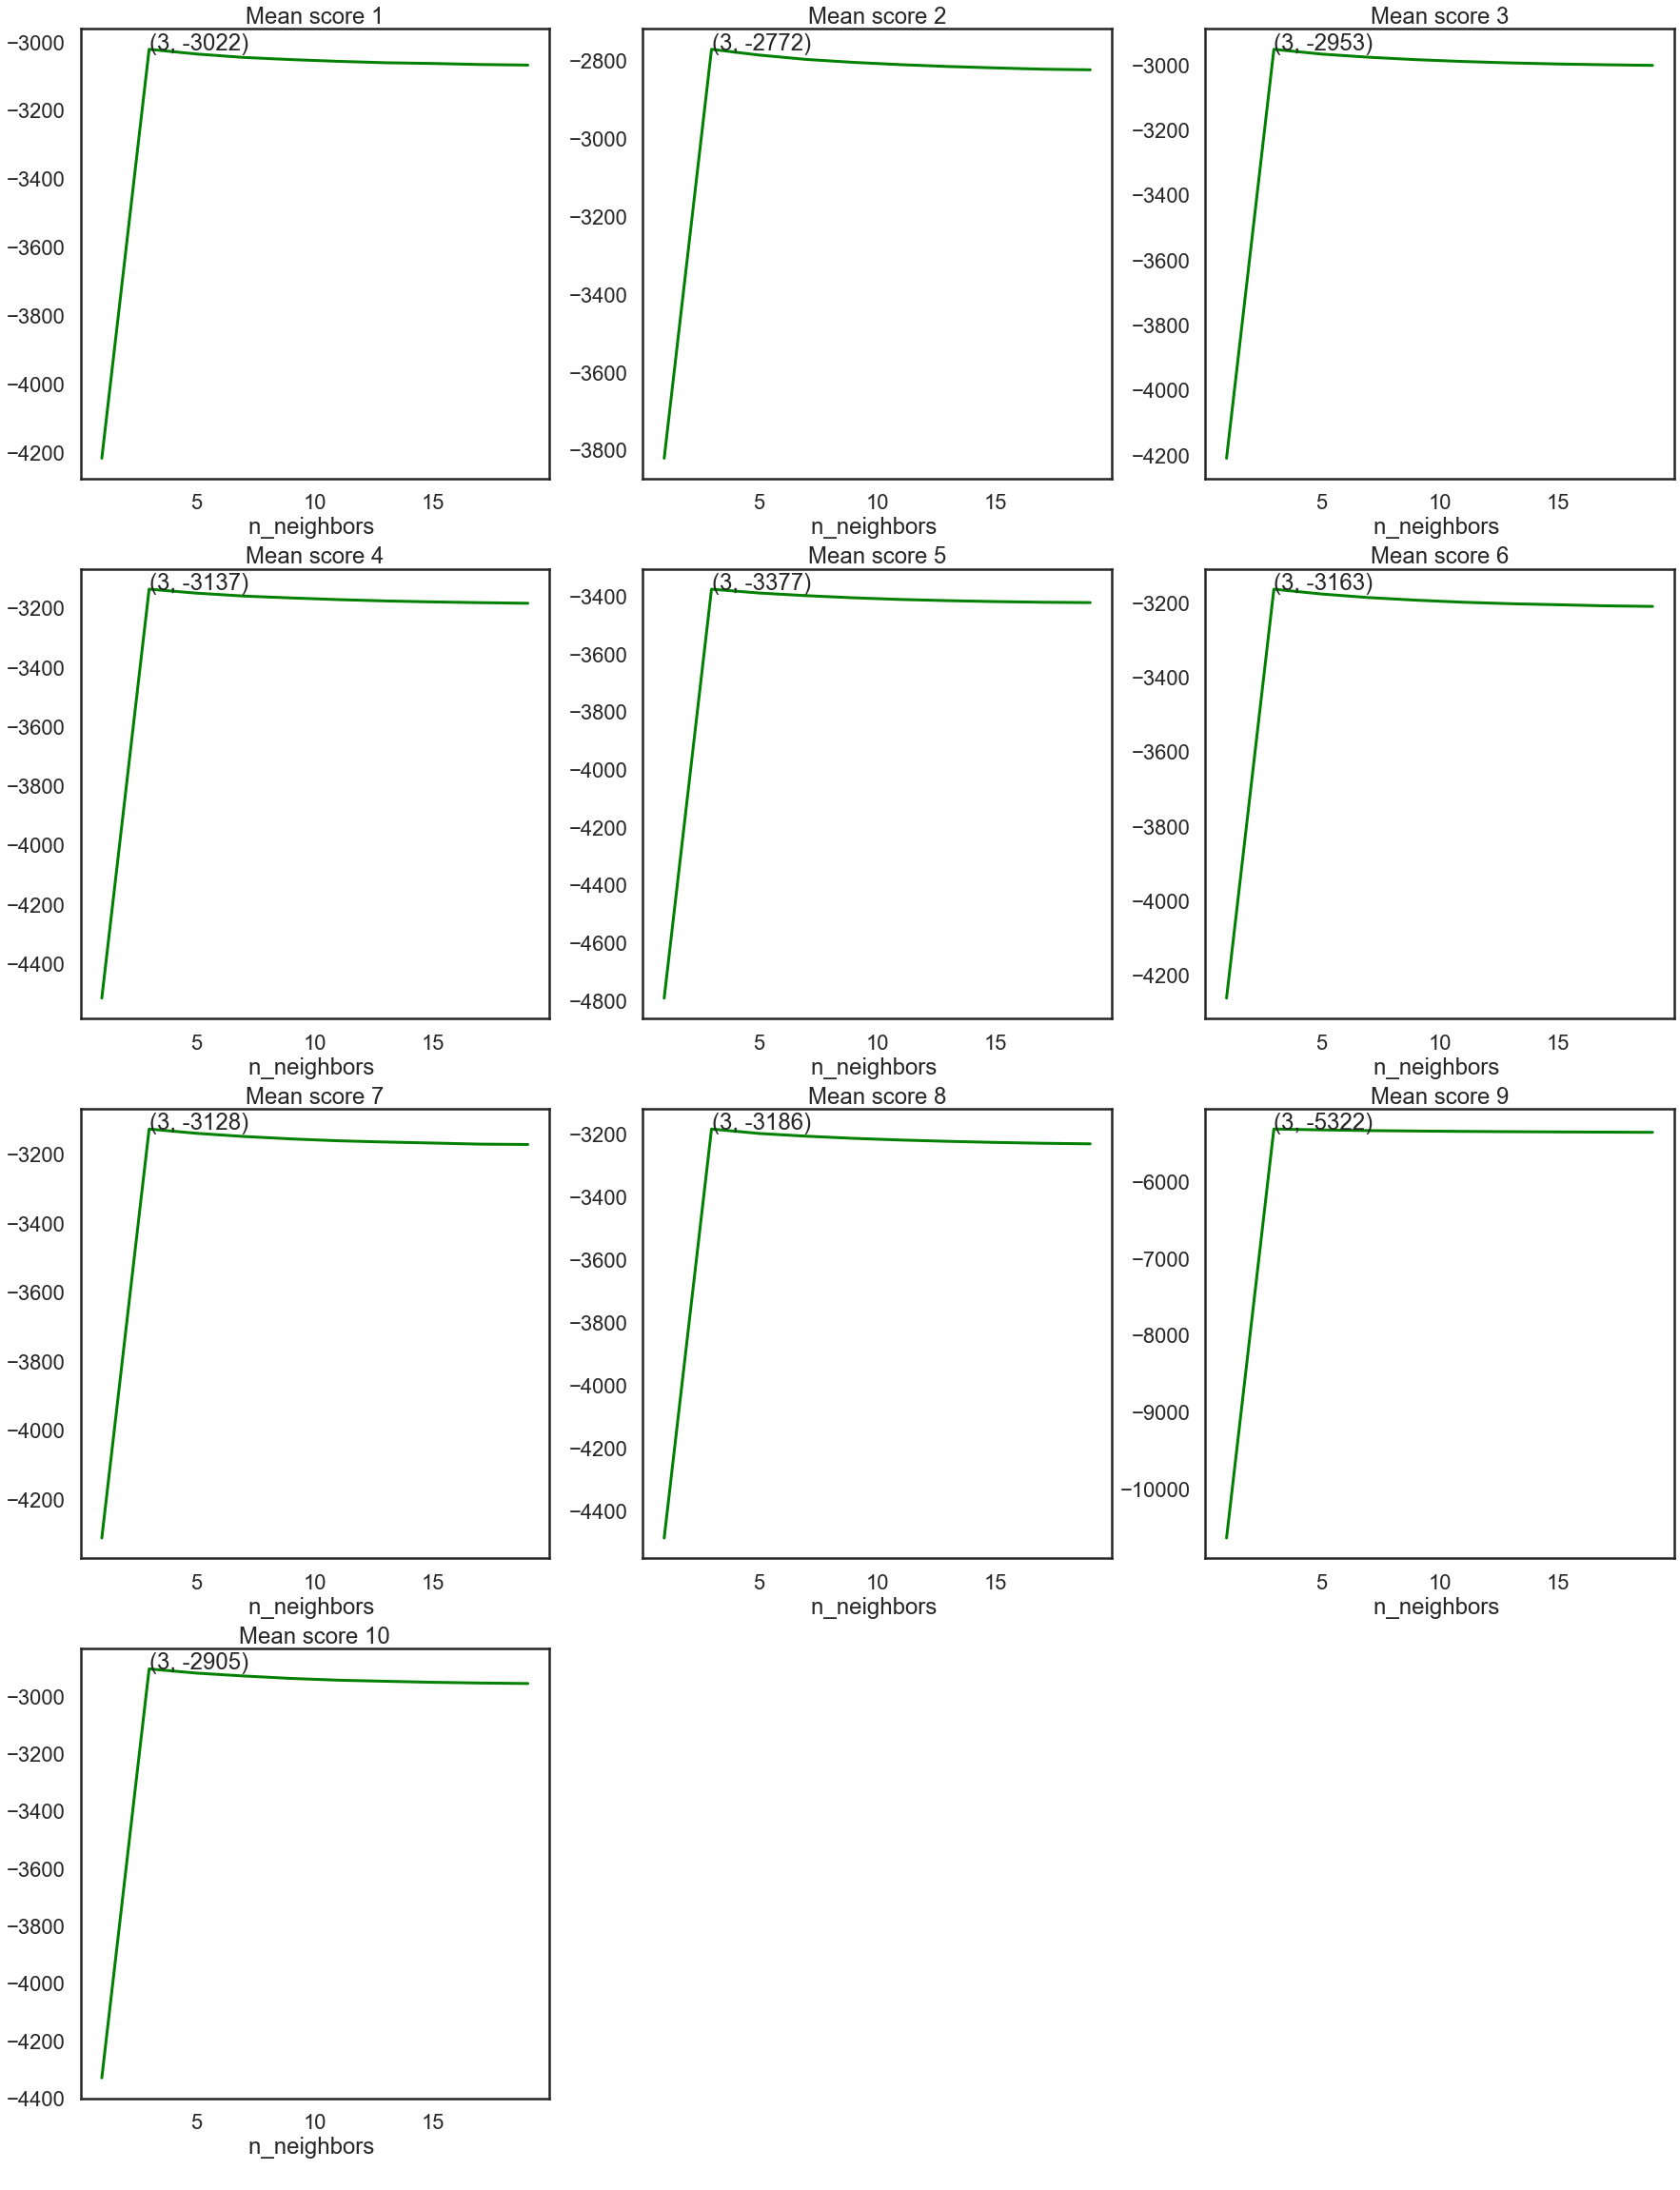

In [90]:
plt.figure(figsize=(30,40))
for n in range(1,11):
    plt.subplot(4,3,n)
    plt.plot(n_neighbors[0:10], mean[str(n)][0:10], color = 'green', label = 'mean' )
    plt.xlabel('n_neighbors \n')
#     plt.ylabel('Mean Score')
    plt.title('Mean score %d'%n)
    for i, j in zip(n_neighbors[0:10], mean[str(n)][0:10]):
        if j == max(mean[str(n)][0:10]):
            plt.text(i,max(mean[str(n)]), '({}, {})'.format(i,int(j)))

Mean of the score is at its peak for n_neighbors=3 and later remain constant for most of the models here.

##### Ploting Standard Deaviation Validation Score for each K value

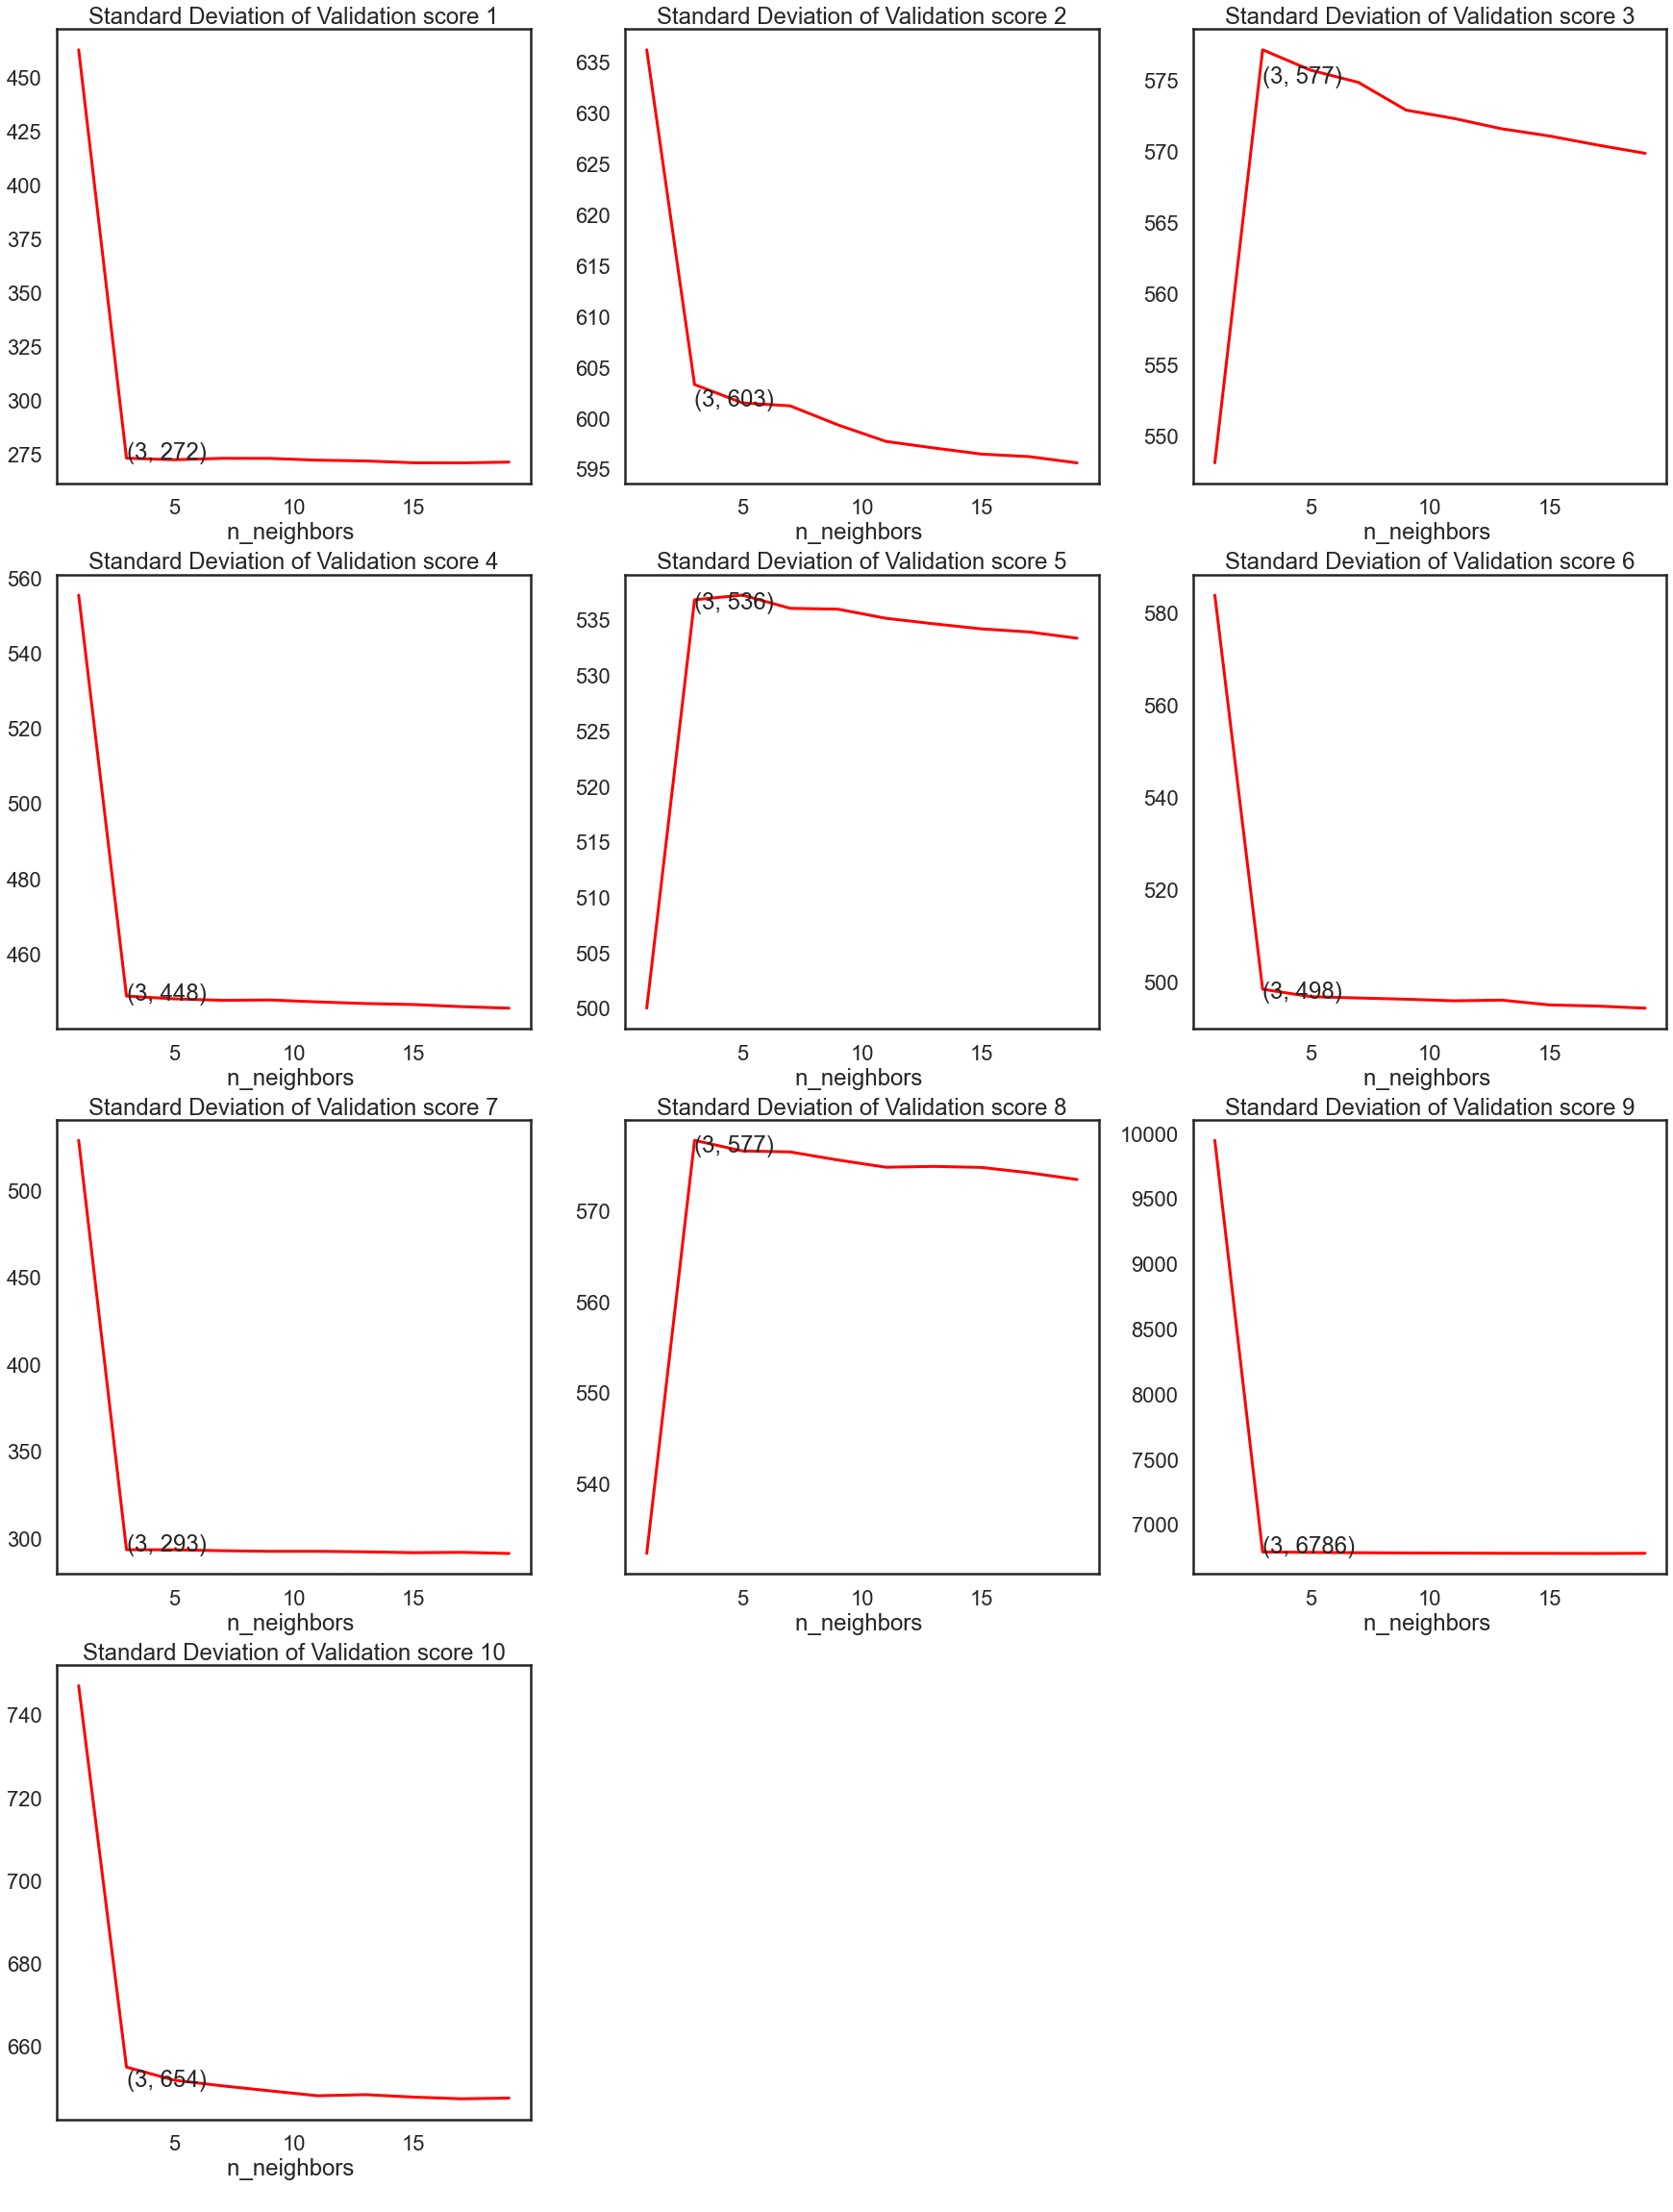

In [91]:
plt.figure(figsize=(30,40))
for n in range(1,11):
    plt.subplot(4,3,n)
    plt.plot(n_neighbors[0:10], std[str(n)][0:10], color = 'red', label = 'Standard deviation' )
    plt.xlabel('n_neighbors \n')
#     plt.ylabel('magnitude')
    plt.title('Standard Deviation of Validation score %d'%n)
    for i, j, k in zip(n_neighbors[0:10], std[str(n)][0:10], mean[str(n)][0:10]):
        if k == max(mean[str(n)][0:10]):
            plt.text(i,std[str(n)][i], '({}, {})'.format(i,int( j)))

Standard deviation of the score is flat for almost all the models for n_neighbors>=3. Hence, we take optimum value of K to be equal or more than 3.

## 3.5 Implementing KNN Regressor for all the datasets

In [92]:
start_KNN = dt.datetime.now()
print("start_KNN:",start_KNN)

start_KNN: 2022-10-20 02:42:34.937723


In [93]:
### **Implementing KNN Regressor**

#import KNN regressor and metric RMSE

from sklearn.neighbors import KNeighborsRegressor as KNN

def Elbow(n, K):
  #initiating empty list
    train_RMSE = []
    test_RMSE = []
  
  #training model for evey value of K
    for i in K:
        #Instance of KNN
        reg = KNN(n_neighbors = i)
        reg.fit(train_x[str(n)], train_y[str(n)])
        
        #Appending RMSE value to empty list claculated using the predictions
        tmp1 = reg.predict(train_x[str(n)])
        tmp1 = MSE(tmp1,train_y[str(n)])**0.5
        train_RMSE.append(tmp1)
        tmp2 = reg.predict(test_x[str(n)])
        tmp2 = MSE(tmp2,test_y[str(n)])**0.5
        test_RMSE.append(tmp2)
    
    return train_RMSE, test_RMSE

# Define K range
k = range(1,20,2)

# Call Elbow function
train = {}
test = {}
for i in range(1,11):
    train["{}".format(i)], test["{}".format(i)] = Elbow(i, k)


In [94]:
for i in range(1,11):
    train["{}".format(i)] = list(map(lambda n: int(n) , train["{}".format(i)]))
    test["{}".format(i)] = list(map(lambda n: int(n), test["{}".format(i)]))


In [95]:
end_KNN = dt.datetime.now()
print("end_KNN:",end_KNN)
KNN_execution_Time = end_KNN - start_KNN
print("KNN_execution_Time:",KNN_execution_Time)

end_KNN: 2022-10-20 03:03:24.629180
KNN_execution_Time: 0:20:49.691457


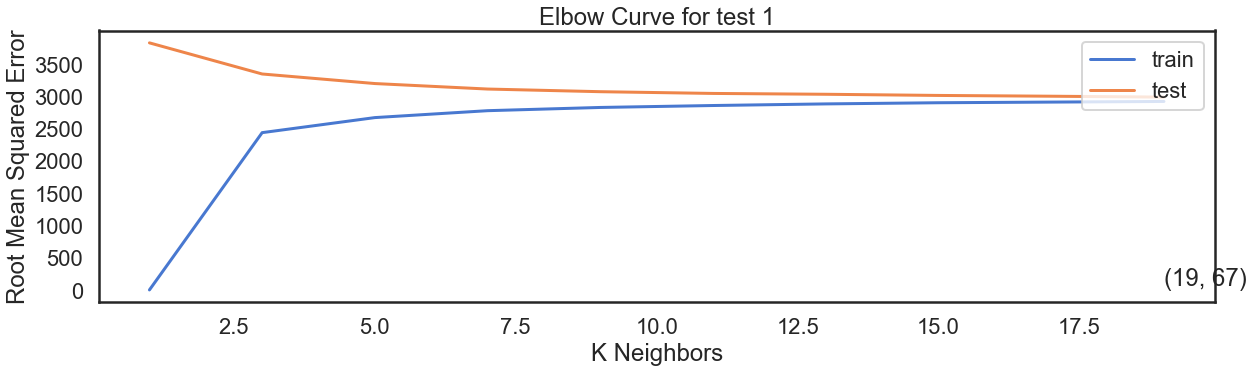

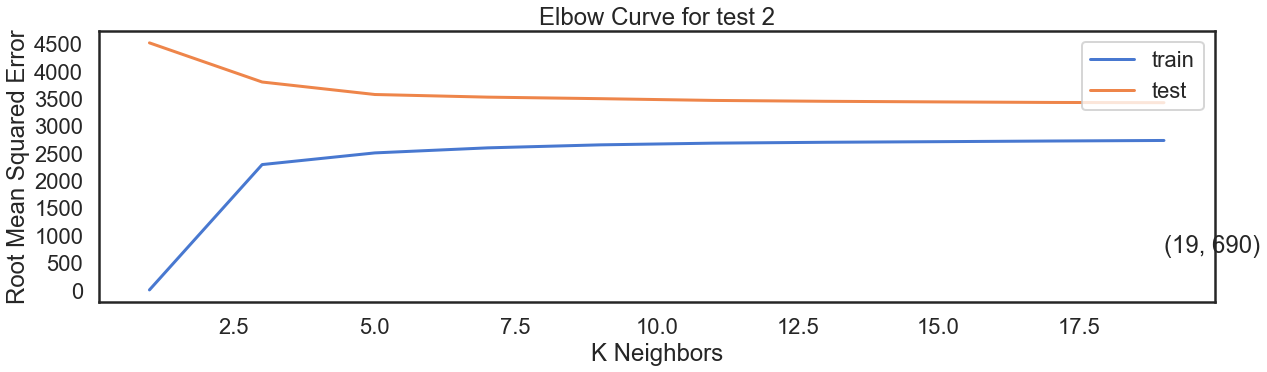

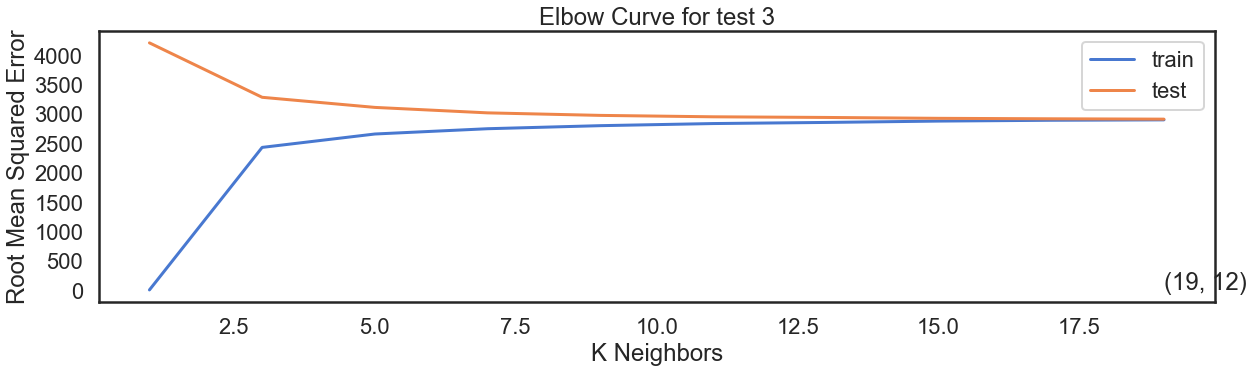

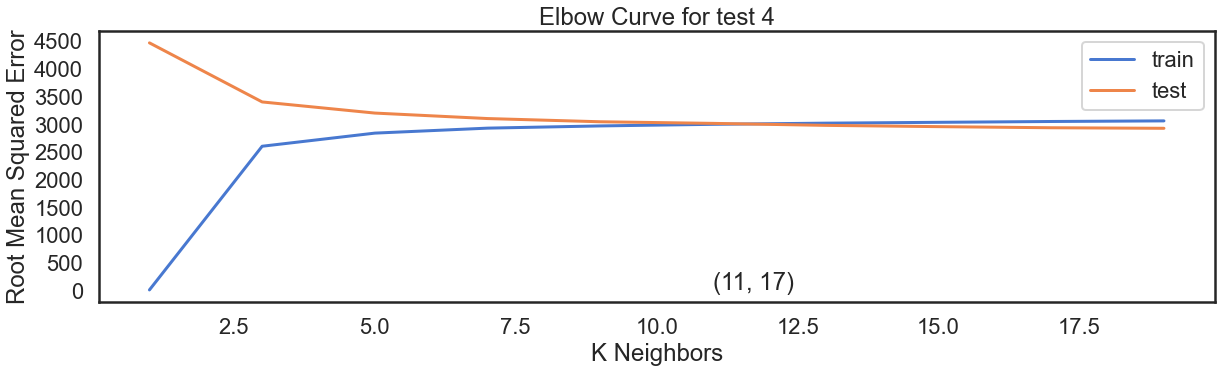

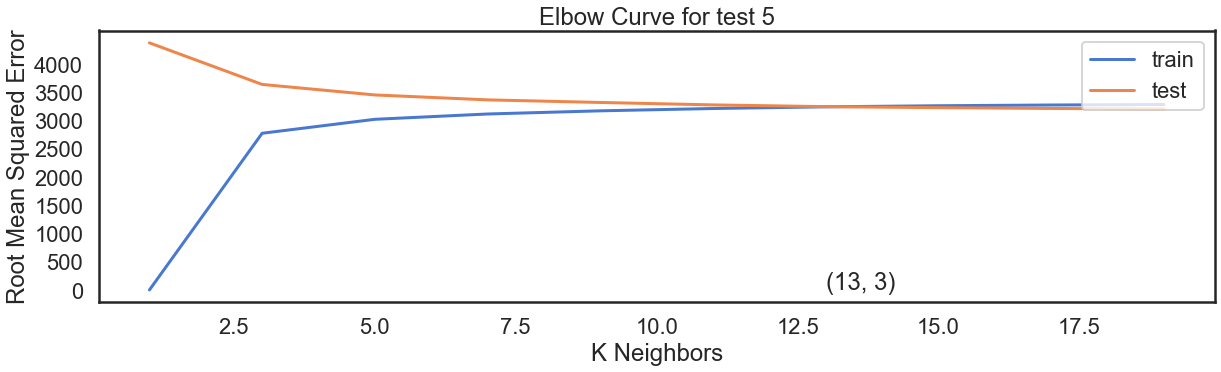

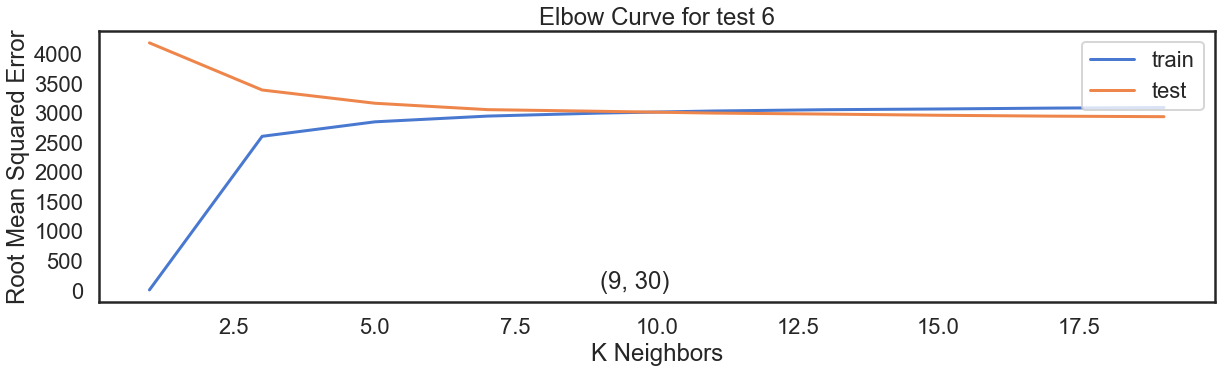

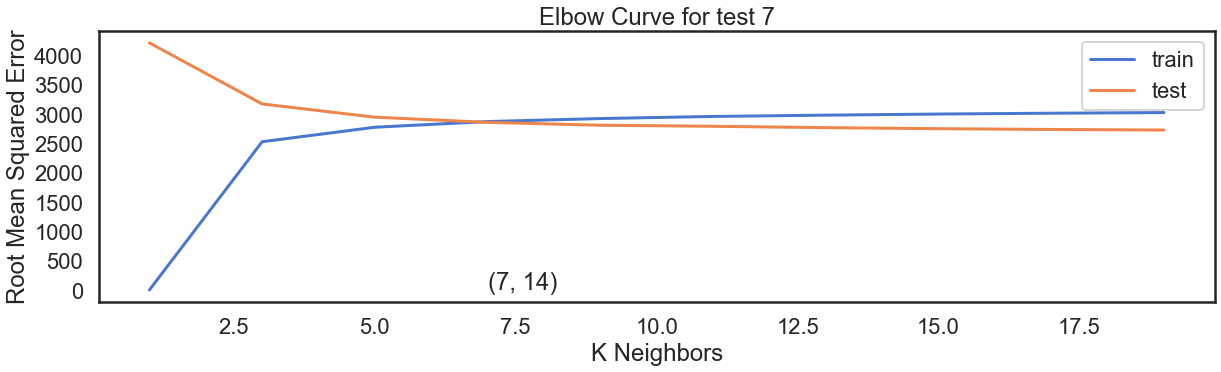

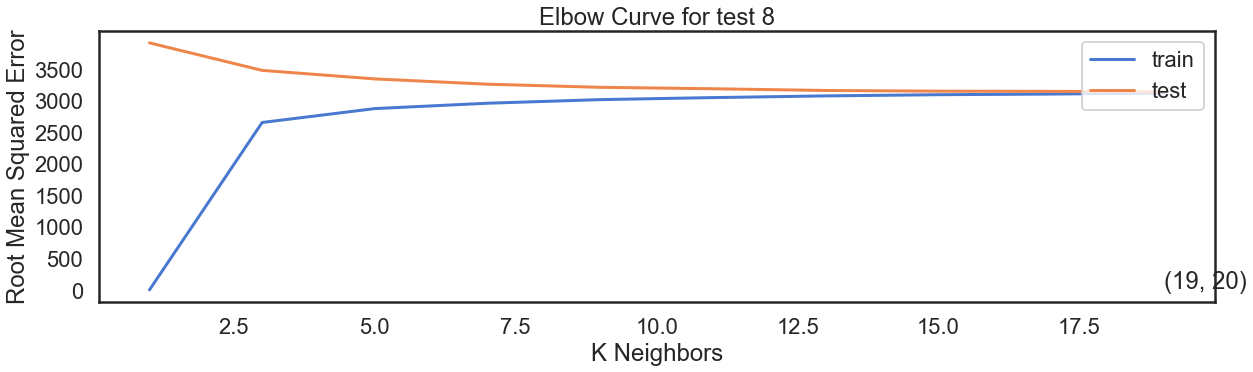

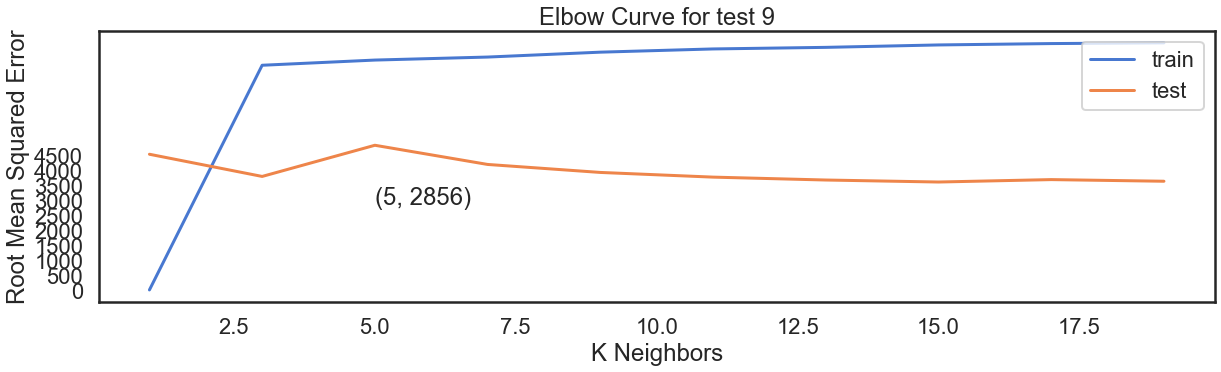

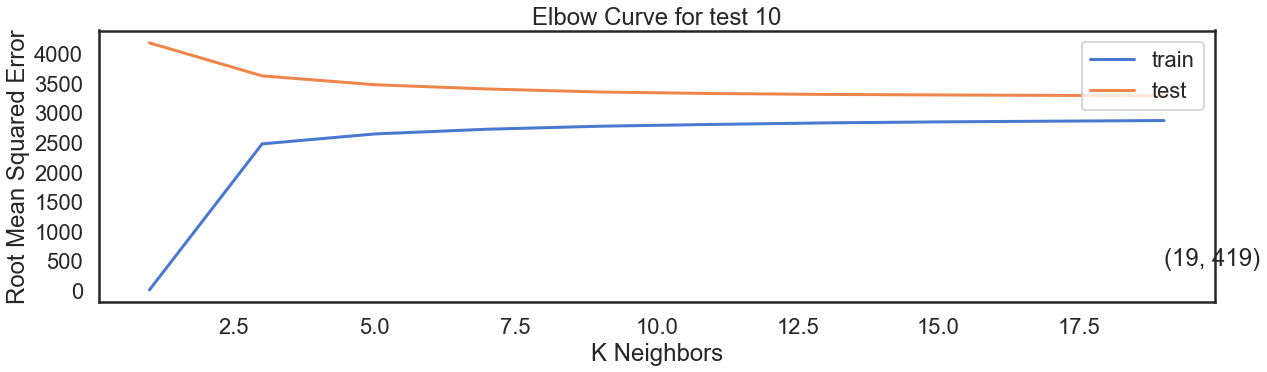

In [96]:
# plot the Train and Test error for different n_neighbors

for n in range(1,11):
    plt.figure(figsize = (20,5))
    plt.plot(k, train[str(n)])
    plt.plot(k, test[str(n)])

    error_dict={}
    error = []
    for i in k:
        err = abs((test[str(n)][(i-1)//2])-(train[str(n)][(i-1)//2]))
        error.append(err)
    error_dict[str(n)]=error

    for i,j in zip(k,error): 
        if j== min(error):
            plt.text(i, min(error),  '({}, {})'.format(i, j))


    plt.xlabel('K Neighbors')
    plt.ylabel('Root Mean Squared Error')
    plt.title('Elbow Curve for test %d'%n)
    plt.yticks(np.arange(min(train[str(n)]), max(test[str(n)])+50,500))
    plt.legend(['train','test'], loc='upper right')
    plt.show()

## 3.6 Implementing kNN with optimum K value

##### Segregating variables: Independent and Dependent Variables

In [97]:
#seperating independent and dependent variables
x = df.drop(['trip_duration'], axis=1)
y = df['trip_duration']
x.shape, y.shape

((726195, 10), (726195,))

##### Scale the Dataset

In [98]:
# Import the MinMax Scaler
# from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

x_scaled= scaler.fit_transform(x)
x.shape, y.shape

((726195, 10), (726195,))

In [99]:
x = pd.DataFrame(x_scaled, columns=x.columns)

##### Split the data to Train and Test set

In [100]:
# Importing Train test split
# from sklearn.model_selection import train_test_split as tts
train_x,test_x,train_y,test_y = tts(x,y, test_size=0.2, random_state = 56)

### **Implementing KNN Regressor**

In [101]:
start_KNN = dt.datetime.now()
print("start_KNN:",start_KNN)

start_KNN: 2022-10-20 03:03:27.542118


In [102]:
#import KNN regressor and metric RMSE

from sklearn.neighbors import KNeighborsRegressor as KNN

def Elbow(K):
  #initiating empty list
    train_RMSE = []
    test_RMSE = []
  
  #training model for evey value of K
    for i in K:
        #Instance of KNN
        reg = KNN(n_neighbors = i)
        reg.fit(train_x, train_y)
        #Appending RMSE value to empty list claculated using the predictions
        tmp1 = reg.predict(train_x)
        tmp1 = MSE(tmp1,train_y)**0.5
        train_RMSE.append(tmp1)
        tmp2 = reg.predict(test_x)
        tmp2 = MSE(tmp2,test_y)**0.5
        test_RMSE.append(tmp2)
    
    return train_RMSE, test_RMSE

# Define K range
k = [3,20]

train=[]
test=[]
# Call Elbow function
train, test = Elbow(k)

In [103]:
# train, test

In [104]:
train = list(map(lambda n: int(n) , train))
test = list(map(lambda n: int(n), test))
error = []
for i in range(len(train)):
    err = test[i] - train[i]
    error.append(err)
print(train,test, error)
# print(test)

[3139, 3878] [3886, 3231] [747, -647]


In [105]:
end_KNN = dt.datetime.now()
print("end_KNN:",end_KNN)
KNN_execution_Time = end_KNN - start_KNN
print("KNN_execution_Time:",KNN_execution_Time)

end_KNN: 2022-10-20 03:29:15.737014
KNN_execution_Time: 0:25:48.194896


In [106]:
knn_score=pd.DataFrame({'train_score':train, 'test_score':test, 'error':error}, 
                       index=k)
knn_score

train_score  test_score  error
3          3139        3886    747
20         3878        3231   -647

    train_score  test_score  error
3          3139        3886    747
20         3878        3231   -647


<Figure size 3600x720 with 0 Axes>

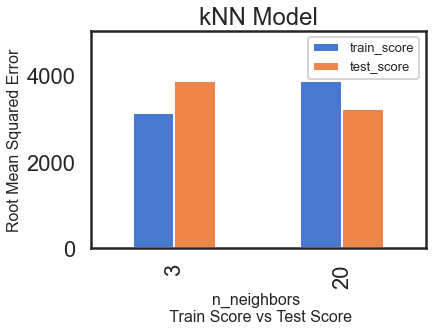

In [107]:
# plot the Train and Test score

plt.figure(figsize = (50,10))
knn_score[['train_score','test_score']].plot(kind='bar')
print(knn_score)
plt.title('kNN Model')    
plt.ylabel('Root Mean Squared Error', fontsize=16)
plt.xlabel('n_neighbors \n Train Score vs Test Score', fontsize=16)
plt.legend(loc='upper right', fontsize=13)
plt.ylim(0,max(knn_score['test_score'])*1.3)
plt.show()

For n_neighbors=20, there is further improvement in Test score, though train error has increased. Thus, optimum value of K is 20.

# 4. Linear Regression

We have already observed linear relationship between some independent variables and the target variable.

In [108]:
df_=df
df_.shape

(726195, 11)

##### Segregating variables: Independent and Dependent Variables

In [109]:
#seperating independent and dependent variables
x = df_.drop(['trip_duration'], axis=1)
y = df_['trip_duration']
x.shape, y.shape

((726195, 10), (726195,))

##### Split the data to Train and Test set

In [110]:
# Importing Train test split
# from sklearn.model_selection import train_test_split as tts
train_x,test_x,train_y,test_y = tts(x,y, test_size=0.2, random_state = 56)

## 4.1 Implementing Linear Regression without Normalization

In [111]:
#import Linear Regression
from sklearn.linear_model import LinearRegression as LR

In [112]:
# Create instance of Linear Regresssion
lr = LR()

# Fit the model
lr.fit(train_x, train_y)

LinearRegression()

In [113]:
# Predicting over the Train & Test Set and calculating error
train_predict = lr.predict(train_x)
train = int(MSE(train_predict, train_y)**0.5)
print('Linear Regression Train and Test Score:')
print('Train Score:', train )
test_predict = lr.predict(test_x)
test = int(MSE(test_predict, test_y)**0.5)
print('Test Score:', test )
error = test-train
print('Error:', error )

Linear Regression Train and Test Score:
Train Score: 3985
Test Score: 3111
Error: -874


In [114]:
lr_score=pd.DataFrame({'train_score':train, 'test_score':test, 'error':error}, 
                      index=[""])
lr_score

train_score  test_score  error
         3985        3111   -874

  train_score  test_score  error
         3985        3111   -874


<Figure size 600x360 with 0 Axes>

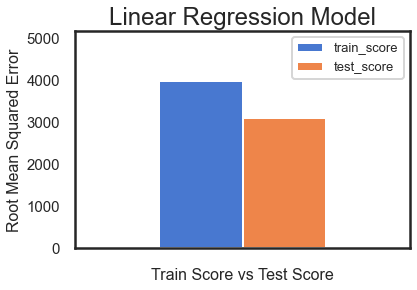

In [115]:
# plot the Train and Test score

plt.figure(figsize = (10,6), dpi=60, facecolor='w', edgecolor='b')
lr_score[['train_score','test_score']].plot(kind='bar')
print(lr_score)
plt.title('Linear Regression Model')    
plt.ylabel('Root Mean Squared Error', fontsize=16)
plt.xlabel('Train Score vs Test Score', fontsize=16)
plt.legend(loc='upper right', fontsize=13)
plt.ylim(0,lr_score['train_score'].max()*1.3)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

Test score has improved significantly compared to KNN Model with n_neighbors=20.

##### Parameters of Linear Regression

In [116]:
lr.coef_

array([  204.69978946,  -565.80401468,   725.0451631 , -1550.65467293,
       -1093.17101436,    23.67022144,    14.18848363,    -6.96060738,
           2.93271646,   148.7332263 ])

In [117]:
x.columns

Index(['vendor_id', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'month_of_year',
       'day_of_week', 'hour_of_day', 'distance_'],
      dtype='object')

##### Plotting the Coefficients

Text(0.5, 1.0, 'Coefficient plot')

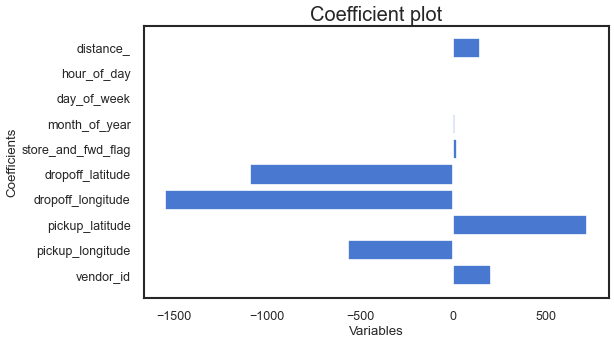

In [118]:
plt.figure(figsize=(10, 6), dpi=60, facecolor='w', edgecolor='b')
i = train_x.columns
j = lr.coef_
plt.barh( i, j )
plt.xlabel( "Variables", fontsize=16)
plt.ylabel('Coefficients', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.title('Coefficient plot')

## 4.2 Checking Assumptions of Linear Model

In [119]:
# Arranging and calculating the Residuals
residuals = pd.DataFrame({
    'fitted values' : test_y,
    'predicted values' : test_predict,
})

residuals['residuals'] = residuals['fitted values'] - residuals['predicted values']
residuals.head()

fitted values  predicted values   residuals
99961            1639       1156.802296  482.197704
705803            293        586.624452 -293.624452
668774           1859       1739.770358  119.229642
413447            826        669.332142  156.667858
517261            488        606.380385 -118.380385

##### Plotting residual curve (Is there constant Variance OR Homoscedastic?)

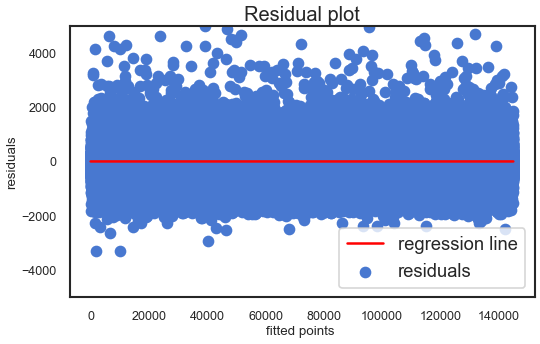

In [121]:
plt.figure(figsize=(10, 6), dpi=60, facecolor='w', edgecolor='b')
f = range(len(residuals[residuals.residuals<5000]))
k = [0 for i in f]
plt.scatter( f, residuals.residuals[residuals.residuals<5000], label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ', fontsize=16)
plt.ylabel('residuals', fontsize=16)
plt.title('Residual plot')
plt.ylim(-5000, 5000)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend()

The Residual plot clearly Looks Homoscedastic, i.e. the the variance of the error across the dataset is nearly constant.
Also, there is almost negligible autocorrelation between the error terms.

##### Checking Distribution of Residuals

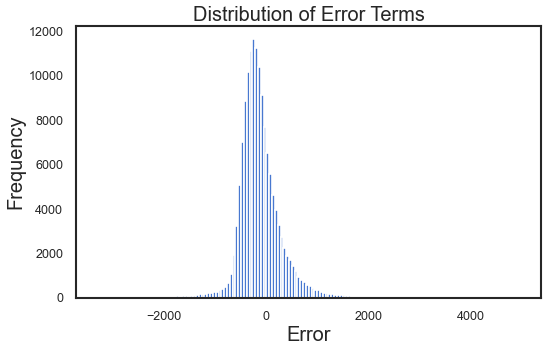

In [122]:
# Histogram for distribution
plt.figure(figsize=(10, 6), dpi=60, facecolor='w', edgecolor='b')
plt.hist(residuals.residuals[residuals.residuals<5000], bins =150)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Distribution of Error Terms')
# plt.xlim(-5000,5000)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

The distribution of error is nearly normal, but there are some outliers on the higher end of the errors which is removed here to view the distribution in better manner.

##### QQ-Plot (Is the data Normally Distributed?)

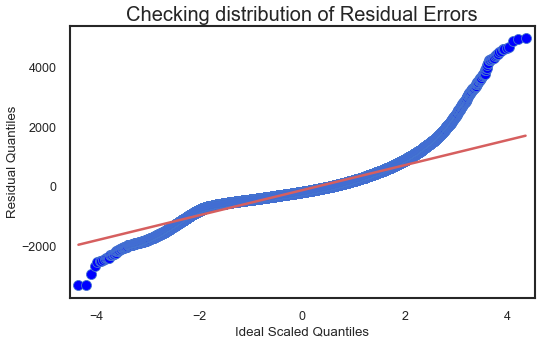

In [123]:
# importing the QQ-plot from the from the statsmodels
from statsmodels.graphics.gofplots import qqplot

## Plotting the QQ plot
fig, ax = plt.subplots(figsize=(10,6) , dpi = 60)
qqplot(residuals.residuals[residuals.residuals<5000], line = 's' , ax = ax)
plt.ylabel('Residual Quantiles',fontsize=16)
plt.xlabel('Ideal Scaled Quantiles',fontsize=16)
plt.title('Checking distribution of Residual Errors')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

Here, QQ-plot also verifies the findings from the residuals histogram distribution i.e., the data is mostly normal in nature. There are some outliers on the higher end of the residues which have been removed for the plot.

##### Variance Inflation Factor (VIF) (Checking for multi collinearity)

In [124]:
# Importing Variance_inflation_Factor funtion from the Statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Calculating VIF for every column
VIF = pd.Series([variance_inflation_factor(df_.values, i) for i in range(df_.shape[1])], 
                index =df_.columns)
VIF

vendor_id             1.055843e+01
pickup_longitude      3.675200e+06
pickup_latitude       2.580897e+06
dropoff_longitude     3.353120e+06
dropoff_latitude      1.903099e+06
store_and_fwd_flag    1.013183e+00
trip_duration         1.081153e+00
month_of_year         5.384445e+00
day_of_week           3.465902e+00
hour_of_day           5.582011e+00
distance_             1.661279e+00
dtype: float64

There are some Independent Variable over the value of 5, which means that there are some features that exhibit Multicollinearity in the dataset.

In [125]:
# identify independent variables with high correlation with other independent variables

for i in range(df_.shape[1]): 
    VIF_new = pd.Series([variance_inflation_factor(df_.values, i) for i in range(df_.shape[1])], 
                        index =df_.columns)
    max_VIF = VIF_new.max()
    max_index = VIF_new.idxmax()

    if max_VIF > 5 :
        df_ = df_.drop([max_index], axis=1)
VIF_new


store_and_fwd_flag    1.006416
trip_duration         1.078976
month_of_year         3.626390
day_of_week           2.668805
hour_of_day           3.438022
distance_             1.547622
dtype: float64

Here are the features that are not highly correlated to each other.

## 4.3 Model Interpretability

To interpret the model, I have normalized the data.

##### Segregating variables: Independent and Dependent Variables

In [126]:
#seperating independent and dependent variables
x = df_.drop(['trip_duration'], axis=1)
y = df_['trip_duration']
x.shape, y.shape

((726195, 5), (726195,))

##### Split the data to Train and Test set

In [127]:
# Importing Train test split
# from sklearn.model_selection import train_test_split as tts
train_x,test_x,train_y,test_y = tts(x,y, test_size=0.2, random_state = 56)

In [128]:
start_LR = dt.datetime.now()
print(start_LR)

2022-10-20 03:29:54.015421


In [129]:
# Creating instance of Linear Regresssion
lr = LR(normalize = True)

# Fitting the model
lr.fit(train_x, train_y)

LinearRegression(normalize=True)

In [130]:
# Predicting over the Train & Test Set and calculating error

train_predict = lr.predict(train_x)
train = MSE(train_predict, train_y)**0.5
test_predict = lr.predict(test_x)
test = MSE(test_predict, test_y)**0.5
print('Train Score', int(train) )
print('Test Score', int(test) )

Train Score 3986
Test Score 3114


In [131]:
lr_score=pd.DataFrame({'train_score':int(train), 'test_score':int(test), 'error':error}, 
                      index=[""])
lr_score

train_score  test_score  error
         3986        3114   -874

  train_score  test_score  error
         3986        3114   -874


<Figure size 600x360 with 0 Axes>

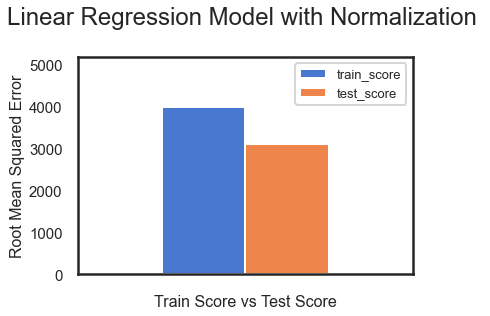

In [132]:
# plot the Train and Test score with Normalization 

plt.figure(figsize = (10,6), dpi=60, facecolor='w', edgecolor='b')
lr_score[['train_score','test_score']].plot(kind='bar')
print(lr_score)
plt.title('Linear Regression Model with Normalization \n')    
plt.ylabel('Root Mean Squared Error', fontsize=16)
plt.xlabel('Train Score vs Test Score', fontsize=16)
plt.legend(loc='upper right', fontsize=13)
plt.ylim(0,lr_score['train_score'].max()*1.3)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

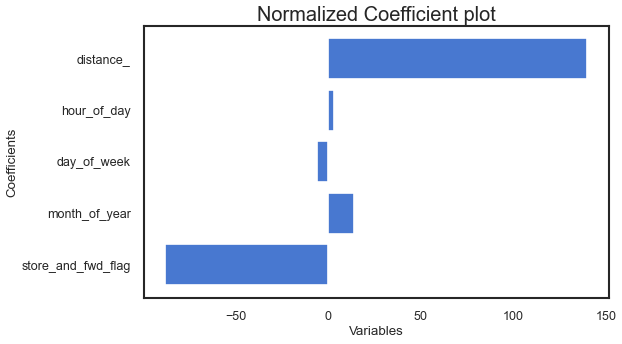

In [133]:
# plot for Normalized coefficient

plt.figure(figsize=(10, 6), dpi=60, facecolor='w', edgecolor='b')
plt.barh( train_x.columns,lr.coef_)
plt.xlabel( "Variables", fontsize=16)
plt.ylabel('Coefficients', fontsize=16)
plt.title('Normalized Coefficient plot')
plt.tick_params(axis='both', which='major', labelsize=15)


There are some Coefficients which are near to zero or negative and not significant. So, I remove them using a threshold and build the model again for interpretability. Also, multicollinearity has been removed from the data using vif > 5 cut-off. 

##### Arranging coefficients with features

In [134]:
Coefficients = pd.DataFrame({
    'Variable'    : x.columns,
    'coefficient' : lr.coef_
})
Coefficients.head()

Variable  coefficient
0  store_and_fwd_flag   -88.232134
1       month_of_year    13.875477
2         day_of_week    -6.208858
3         hour_of_day     3.327853
4           distance_   140.045236

##### Chossing variables with sigificance greater than 0.5 ( Filtering Significant Features)

In [135]:
# Filtering out coefficients by using Threshold
sig_var = Coefficients[Coefficients.coefficient > 0.5] 

##### Extracting the significant subset do independent Variables

In [136]:
# Significant variables with coefficient >0.5
subset = df_[sig_var['Variable'].values] 
subset.head()

month_of_year  hour_of_day  distance_
0              1           23          6
1              6            9          0
2              6           15          0
3              2           16          3
4              2           22          8

##### Splitting the data into train set and the test set

In [137]:
# Importing the train test split function
# from sklearn.model_selection import train_test_split as tts
train_x,test_x,train_y,test_y = tts(subset, y , test_size=0.2, random_state = 56)

##### Training Model

In [138]:
# Creating instance of Linear Regresssion with Normalised Data
lr = LR(normalize = True)

# Fitting the model
lr.fit(train_x, train_y)

LinearRegression(normalize=True)

##### Predicting over the train and test set

In [139]:
# Predicting over the Train - Test Set and calculating error
train_predict = lr.predict(train_x)
train = MSE(train_predict, train_y)**0.5
print('Train Score', int(train) )
test_predict = lr.predict(test_x)
test = MSE(test_predict, test_y)**0.5
print('Test Score', int(test) )

Train Score 3986
Test Score 3114


##### Plotting the coefficients

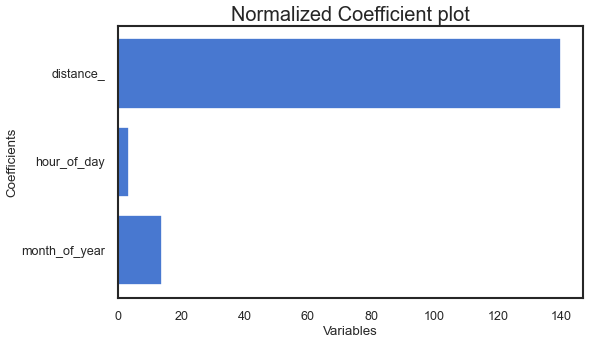

In [140]:
plt.figure(figsize=(10, 6), dpi=60, facecolor='w', edgecolor='b')
x = train_x.columns
y = lr.coef_
plt.barh( x, y )
plt.xlabel( "Variables", fontsize=16)
plt.ylabel('Coefficients', fontsize=16)
plt.title('Normalized Coefficient plot')
plt.tick_params(axis='both', which='major', labelsize=15)

Here, **distance** variable is the most significant feature in predicting the target variable accurately.

In [141]:
end_LR = dt.datetime.now()
LR_exec_time = end_LR-start_LR
print(LR_exec_time)

0:00:01.121482


## 4.4 Lasso Regularisation 

##### Segregating variables: Independent and Dependent Variables

In [295]:
# seperating independent and dependent variables
x = df.drop(['trip_duration'], axis=1)
y = df['trip_duration']
x.shape, y.shape

((726195, 10), (726195,))

##### Split the data to Train and Test set

In [296]:
# Importing Train test split
# from sklearn.model_selection import train_test_split as tts
train_x,test_x,train_y,test_y = tts(x,y, test_size=0.2, random_state = 56)

In [297]:
#Separating the independent and dependent variables
X_train = train_x.values
y_train = train_y.values
X_test = test_x.values
y_test = test_y.values
X_train.shape, X_test.shape

((580956, 10), (145239, 10))

Training Error 15896011
Testing Error 9700556


(580956,)

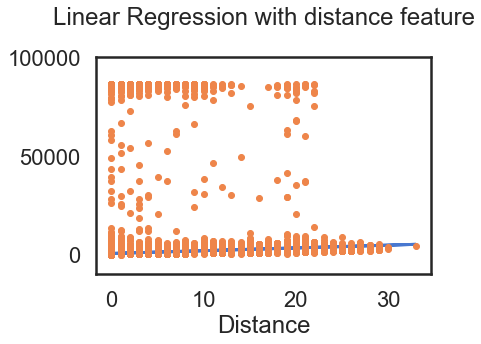

In [298]:
# Linear regression with one feature
train = X_train[:,9:10]

lr = LR(normalize=True) #scaling
lr.fit(train,y_train) 
train_pred = lr.predict(train)

rss_train = sum((train_pred-y_train)**2) / X_train.shape[0] 

test = X_test[:,9:10]
test_pred = lr.predict(test)
rss_test = sum((test_pred-y_test)**2)/ X_test.shape[0]

print("Training Error", int(rss_train))
print("Testing Error",int(rss_test))

plt.plot(X_train[:,9],train_pred)
plt.plot(X_train[:,9],y_train,'.')
plt.title("Linear Regression with distance feature\n")
plt.xlabel("Distance")
plt.ylim(-10000,100000)
train_pred.shape

##### Lasso Regularisation

In [148]:
# Importing Lasso model from sklearn's linear_model module
from sklearn.linear_model import Lasso

In [149]:
# Alpha values to test regularisation
alpha_lasso = [0, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

In [150]:
# defining a function which will fit lasso regression model, plot the results, and return the coefficients
def lasso_regression(train_x, train_y, test_x, test_y, alpha, models_to_plot={}):
    
    #Fit the model
    if alpha == 0:
        lasso_R = LR(normalize=True)
        lasso_R.fit(train_x, train_y)
        train_pred = lasso_R.predict(train_x)
        test_pred = lasso_R.predict(test_x)
        
    else:
        lasso_R = Lasso(alpha=alpha,normalize=True)
        lasso_R.fit(train_x,train_y)
        train_pred = lasso_R.predict(train_x)
        test_pred = lasso_R.predict(test_x)
    
    # Plot for alpha value
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(train_x[:,9],train_pred)
        plt.plot(train_x[:,9],train_y,'.')
        plt.title('Plot for alpha: %.3g'%alpha, fontsize=16)
        plt.tick_params(axis='both', which='major', labelsize=13)
        plt.ylim(-10000,100000)
    
    # MRSS
    mrss_train = sum((train_pred-train_y)**2)/train_x.shape[0]
    ret = [mrss_train]
    
    mrss_test = sum((test_pred-test_y)**2)/test_x.shape[0]
    ret.extend([mrss_test])
    
    ret.extend([lasso_R.intercept_])
    ret.extend(lasso_R.coef_)
    
    return ret

In [151]:
#Initialize the dataframe to store coefficients
col = ['mrss_train','mrss_test','intercept'] + ['coef_Var_%d'%i for i in range(1,11)]
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(0,10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

In [152]:
# models to plot
models_to_plot = {0:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 1:236}

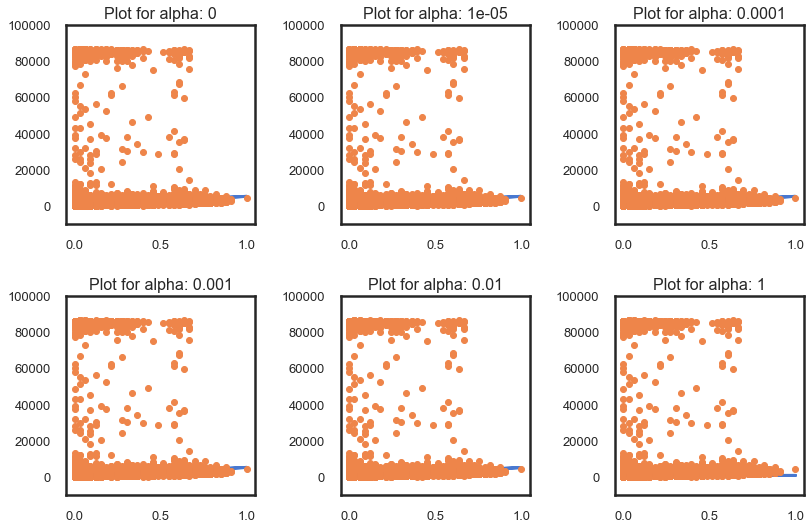

In [153]:
# Plot for 10 alpha values:
plt.figure(figsize=(12,8))
for i in range(10):
    coef_matrix_lasso.iloc[i,] = lasso_regression(train_x.values, train_y.values, test_x.values, test_y.values, alpha_lasso[i], models_to_plot)

In [154]:
# Effect of Lasso Regularisation on train and test score and variable coefficients
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_lasso

mrss_train mrss_test intercept coef_Var_1 coef_Var_2 coef_Var_3  \
alpha_0         1.6e+07   9.7e+06   5.7e+02      2e+02     -2e+02    2.2e+02   
alpha_1e-10     1.6e+07   9.7e+06   5.7e+02      2e+02     -2e+02    2.2e+02   
alpha_1e-08     1.6e+07   9.7e+06   5.7e+02      2e+02     -2e+02    2.2e+02   
alpha_1e-05     1.6e+07   9.7e+06   5.7e+02      2e+02     -2e+02    2.2e+02   
alpha_0.0001    1.6e+07   9.7e+06   5.7e+02      2e+02   -1.9e+02    2.1e+02   
alpha_0.001     1.6e+07   9.7e+06   5.8e+02      2e+02   -1.8e+02      2e+02   
alpha_0.01      1.6e+07   9.7e+06   6.1e+02    1.9e+02        -62         19   
alpha_1         1.6e+07     1e+07   9.5e+02          0          0         -0   
alpha_5         1.6e+07     1e+07   9.5e+02          0          0         -0   
alpha_10        1.6e+07     1e+07   9.5e+02          0          0         -0   

             coef_Var_4 coef_Var_5 coef_Var_6 coef_Var_7 coef_Var_8  \
alpha_0        -5.4e+02   -3.3e+02         24         71        -42   
alpha_1e-10    -5.4e+02   -3.3e+02         24         71        -42   
alpha_1e-08    -5.4e+02   -3.3e+02         24         71        -42   
alpha_1e-05    -5.4e+02   -3.3e+02         24         71        -42   
alpha_0.0001   -5.4e+02   -3.3e+02         23         71        -42   
alpha_0.001    -5.3e+02   -3.2e+02         13         69        -40   
alpha_0.01     -3.9e+02   -2.3e+02          0         49        -19   
alpha_1               0         -0          0          0         -0   
alpha_5               0         -0          0          0         -0   
alpha_10              0         -0          0          0         -0   

             coef_Var_9 coef_Var_10  
alpha_0              67     4.9e+03  
alpha_1e-10          67     4.9e+03  
alpha_1e-08          67     4.9e+03  
alpha_1e-05          67     4.9e+03  
alpha_0.0001         67     4.9e+03  
alpha_0.001          65     4.9e+03  
alpha_0.01           43     4.7e+03  
alpha_1               0           0  
alpha_5               0           0  
alpha_10              0           0

<Figure size 600x360 with 0 Axes>

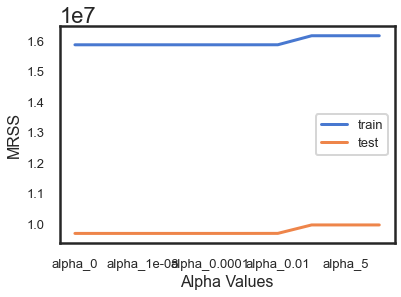

In [155]:
plt.figure(figsize=(10, 6), dpi=60, facecolor='w', edgecolor='b')
coef_matrix_lasso[['mrss_train','mrss_test']].plot()
plt.xlabel('Alpha Values', fontsize=16)
plt.ylabel('MRSS', fontsize=16)
plt.legend(['train', 'test'], fontsize=13)
plt.tick_params(axis='both', which='major', labelsize=13)

In [156]:
# number of columns with row values = 0; 0 coefficients imply feature is removed
coef_matrix_lasso.apply(lambda x: sum(x.values==0),axis=1) 

alpha_0          0
alpha_1e-10      0
alpha_1e-08      0
alpha_1e-05      0
alpha_0.0001     0
alpha_0.001      0
alpha_0.01       1
alpha_1         10
alpha_5         10
alpha_10        10
dtype: int64

Here, regularisation do not seem to affect the model much. 

# 5. Decision Tree Model

##### Segregating variables - Dependent & Independent 

In [157]:
#seperating independent and dependent variables

x = df.drop(['trip_duration'], axis=1)
y = df['trip_duration']

##### Split the dataset 

In [158]:
# from sklearn.model_selection import train_test_split as tts
train_x,test_x,train_y,test_y = tts(x,y, test_size=0.2 ,random_state = 56)

In [159]:
# import sklearn.metrics
# dir(sklearn.metrics)
# sklearn.metrics.SCORERS.keys()

## 5.1 Import Decision Tree Regressor

In [160]:
#importing Decision tree 
from sklearn.tree import DecisionTreeRegressor as DTR

# Creating instance of Tree
model =  DTR( criterion='mse', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
           max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, ccp_alpha=0.0,)

# Fitting the model
model.fit(train_x, train_y)
train_score = model.score(train_x, train_y)
print("Train R-squared:", train_score) 

Train R-squared: 0.9999999292145973


In [161]:
# Predicting over the Train and Test Set
train_pred = model.predict(train_x)
test_pred = model.predict(test_x)
train_RMSE = MSE(train_y, train_pred)**(0.5)
test_RMSE = MSE(test_y, test_pred)**(0.5)
print("Train score:", int(train_RMSE))
print("Test score:", int(test_RMSE))

Train score: 1
Test score: 8546


## 5.2 Hyperparameters Tuning

In [164]:
# calc_score function to calculate model score
def calc_score(model, train_x, train_y, test_x, test_y):
    
    model.fit(train_x, train_y)
    
    pred = model.predict(train_x)
    score_1 = MSE(pred, train_y)**0.5
    
    pred = model.predict(test_x)
    score_2 = MSE(pred, test_y)**0.5
    
    return score_1, score_2 

In [165]:
# plot function to plot Train and Test score
def plot(train_score, test_score, x_axis, title, parameter):
    plt.figure(figsize=(10,6), dpi=60)
    plt.plot(x_axis, train_score, label='train_score')
    plt.plot(x_axis, test_score, label='test_score')
    plt.title(title)
    plt.legend(['train','test'])
    plt.xlabel(parameter)
    plt.ylabel("Root Mean Squared Error")
    plt.show()

In [166]:
from sklearn.tree import DecisionTreeRegressor as DTR

# optimum max depth hyperparameter

depth = range(3,10)
train = []
test = []

for i in depth:
    model = DTR(max_depth= i, random_state=42)
    
    train_score, test_score = calc_score(model, train_x, train_y, test_x, test_y)
    train.append(train_score)
    test.append(test_score)
    
performance = pd.DataFrame({'max_depth':depth,'Train_score':train,'Test_score':test})

performance.head()

max_depth  Train_score  Test_score
0          3        4e+03     3.1e+03
1          4        4e+03     3.1e+03
2          5      3.1e+03     7.8e+03
3          6      3.1e+03     7.8e+03
4          7        3e+03     7.8e+03

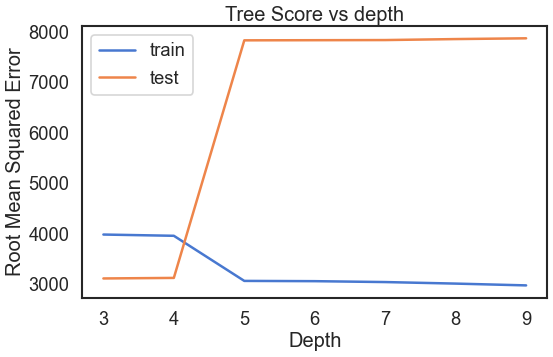

In [167]:
plot(train, test, depth, 'Tree Score vs depth', 'Depth')

In [168]:
# optimum min sample leaf hyperparameter

sam_leaf = range(1,30,2)
train = []
test = []

for sam in sam_leaf:
    model = DTR(min_samples_leaf= i, random_state=42)
    
    train_score, test_score = calc_score(model, train_x, train_y, test_x, test_y)
    train.append(train_score)
    test.append(test_score)
    
performance = pd.DataFrame({'min_samples_leaf':sam_leaf,'Train_score':train,'Test_score':test})

performance.head()

min_samples_leaf  Train_score  Test_score
0                 1      3.7e+03     3.4e+03
1                 3      3.7e+03     3.4e+03
2                 5      3.7e+03     3.4e+03
3                 7      3.7e+03     3.4e+03
4                 9      3.7e+03     3.4e+03

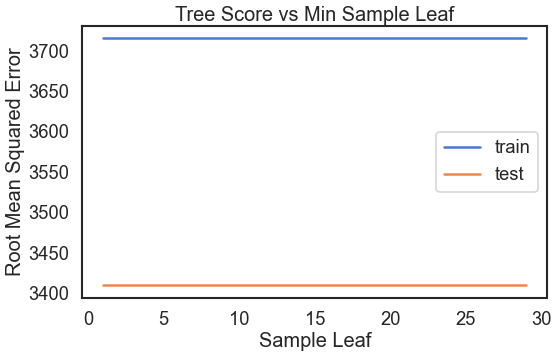

In [169]:
plot(train, test, sam_leaf, 'Tree Score vs Min Sample Leaf', 'Sample Leaf')

In [170]:
# optimum min sample split hyperparameter

sam_split = range(1,30,2)
train = []
test = []

for sam in sam_split:
    model = DTR(min_samples_split= i, random_state=42)
    
    train_score, test_score = calc_score(model, train_x, train_y, test_x, test_y)
    train.append(train_score)
    test.append(test_score)
    
performance = pd.DataFrame({'min_samples_split':sam_split,'Train_score':train,'Test_score':test})

performance.head()

min_samples_split  Train_score  Test_score
0                  1      1.6e+03     8.4e+03
1                  3      1.6e+03     8.4e+03
2                  5      1.6e+03     8.4e+03
3                  7      1.6e+03     8.4e+03
4                  9      1.6e+03     8.4e+03

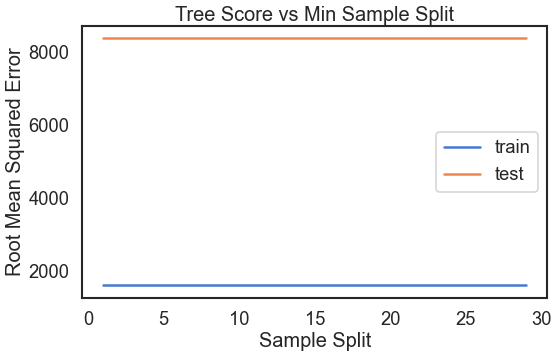

In [171]:
plot(train, test, sam_split, 'Tree Score vs Min Sample Split', 'Sample Split')

In [172]:
# optimum max leaf node hyperparameter
leaf_node = range(1,30,2)
train = []
test = []

for sam in leaf_node:
    model = DTR(max_leaf_nodes= i, random_state=42)
    
    train_score, test_score = calc_score(model, train_x, train_y, test_x, test_y)
    train.append(train_score)
    test.append(test_score)
    
performance = pd.DataFrame({'max_leaf_nodes':leaf_node,'Train_score':train,'Test_score':test})

performance.head()

max_leaf_nodes  Train_score  Test_score
0               1      3.1e+03     7.8e+03
1               3      3.1e+03     7.8e+03
2               5      3.1e+03     7.8e+03
3               7      3.1e+03     7.8e+03
4               9      3.1e+03     7.8e+03

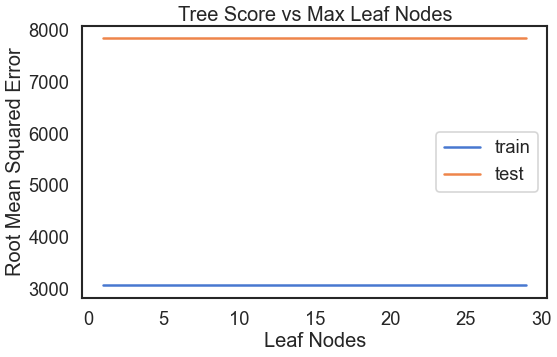

In [173]:
plot(train, test, leaf_node, 'Tree Score vs Max Leaf Nodes', 'Leaf Nodes')

## 5.3 Implementing Decision Tree

In [174]:
# Implement Decision Tree with hyperparameter tuning
model = DTR(max_depth=4)
model.fit(train_x, train_y)
feature_imp = pd.Series(model.feature_importances_, index=x.columns)
k = feature_imp.sort_values()

Text(0.5, 1.0, 'Feature importance')

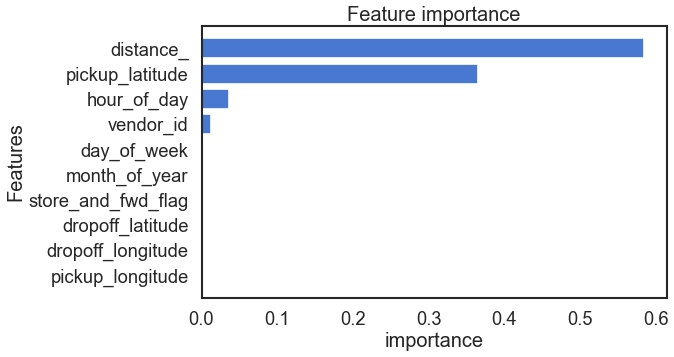

In [175]:
plt.figure(figsize=(10,6), dpi=60)
plt.barh(k.index, k)
plt.xlabel('importance')
plt.ylabel('Features')
plt.title('Feature importance')

From the above feature importance plot of the model, we derive that **distance** is the most important feature for this model.

##### Plotting the Train and Test score

In [176]:
# Predicting over the Train and Test Set
train_pred = model.predict(train_x)
test_pred = model.predict(test_x)
train_RMSE = MSE(train_y, train_pred)**(0.5)
test_RMSE = MSE(test_y, test_pred)**(0.5)
print("Train score:", int(train_RMSE))
print("Test score:", int(test_RMSE))

Train score: 3960
Test score: 3125


In [177]:
DTR_score = pd.DataFrame({'train_score':int(train_RMSE), 'test_score':int(test_RMSE)},
                         index=[""])

  train_score  test_score
         3960        3125


<Figure size 600x360 with 0 Axes>

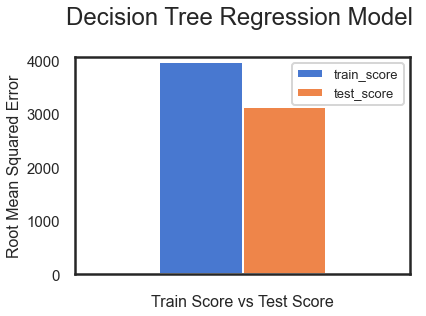

In [178]:
# plot the Curves

plt.figure(figsize = (10,6), dpi=60, facecolor='w', edgecolor='b')
DTR_score[['train_score','test_score']].plot(kind='bar')
print(DTR_score)
plt.title('Decision Tree Regression Model \n')    
plt.ylabel('Root Mean Squared Error', fontsize=16)
plt.xlabel('Train Score vs Test Score', fontsize=16)
plt.legend(loc='upper right', fontsize=13)
plt.ylim(0,DTR_score['test_score'].max()*1.3)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [179]:
End = dt.datetime.now()
print("End:",End)

End: 2022-10-20 03:35:07.244304


In [180]:
Total_Execution_Time = End - Start
print('Total_Execution_Time:',Total_Execution_Time)

Total_Execution_Time: 1:28:16.388422
